# Mini Project DQN

## 1: Introduction

In [69]:
""" Import environment """
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch

%matplotlib inline

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


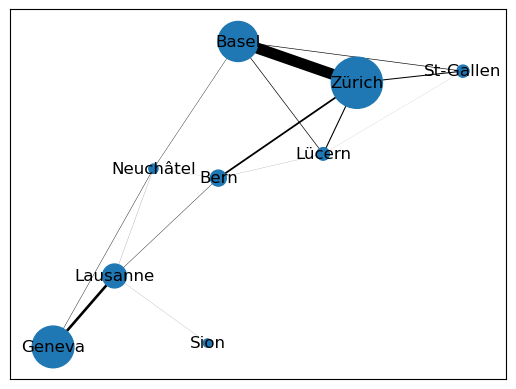

In [70]:
""" load the switzerland map"""
dyn = ModelDynamics('config/switzerland.yaml')
print(dyn.cities)
dyn.draw_map()

In [72]:
""" Define function to plot info in an episode """
def plot(log, action=True):
    """ Divide the log into the different cities and plot the infected and dead people for each city """
    total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
    cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    """ Plot the full state, the observable state and the actions"""
    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2) if action else None
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    if action:
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title('Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

#### Question 1a: study the behavior of the model when epidemics are unmitigated

In [73]:
""" Initialize environment """
env = Env(dyn)

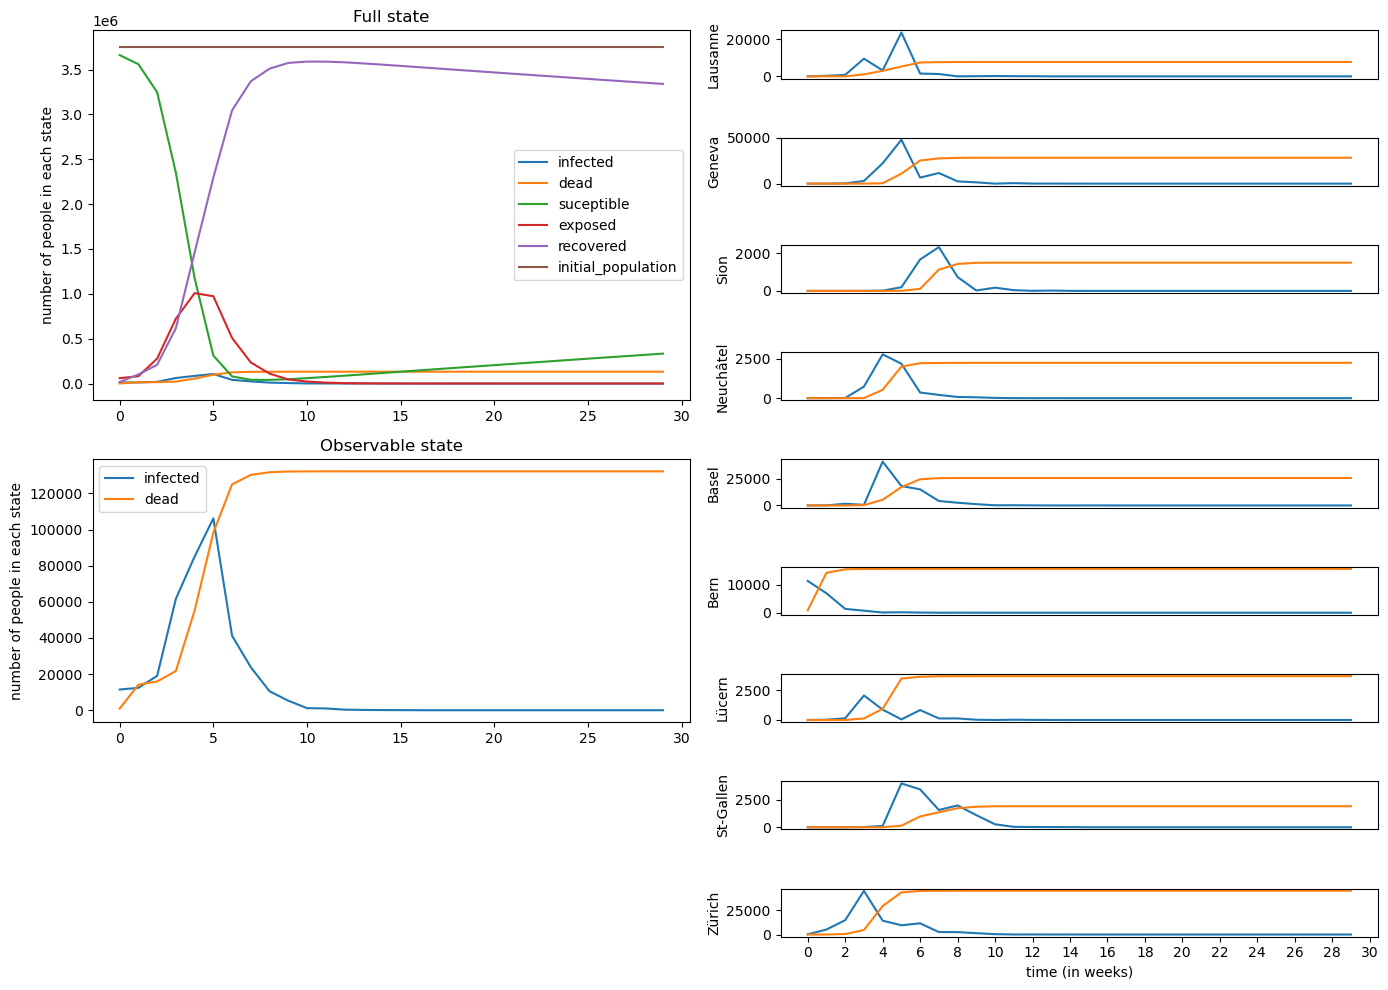

In [208]:
""" Run unmitigated """
seed = 42

unmitigated = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed=seed)
while not finished:
    action = unmitigated
    obs, reward, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Plot the episode """
plot(log,action=False)

## 2: Prof. Russo's Policy

### Question 2a: Implement Professor Russo’s Policy

In [76]:
""" Implement the Pr. Russo's Policy in the form of python class"""
class Russo(Agent):
    def __init__(self, env):
        self.env = env
        self.confine_index = 0
    
    def load_model(self, savepath):
        pass

    def save_model(self, savepath):
        pass

    def optimize_model(self):
        return 0
    
    def reset(self):
        self.confine_index = 0
    
    def act(self, obs):
        # If the action is not confinement, and infected people are more than 20000, then confine for 4 weeks
        if self.confine_index == 0 and obs.total.infected[-1] > 20000:
            self.confine_index = 4
            
        # Action for the weeks of confinement
        if self.confine_index > 0:
            self.confine_index -= 1
            confine_state = True
        else:
            confine_state = False

        action = {
            'confinement': confine_state,
            'isolation': False,
            'hospital': False,
            'vaccinate': False,
        }
        
        return action
    


In [77]:
""" Initialize the environment and agent """
env = Env(dyn)
agent = Russo(env)
seed = 42

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed=seed)
while not finished:
    action = agent.act(obs)
    obs, reward, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

### Question 2b: Evaluate Pr. Russo’s Policy

In [78]:
""" Evaluate the policy, save confined day, reward, and total death. For each episode, save the mentioned values"""
def evaluate(agent, env, episodes=50,seed=42):
    log_confine = []
    log_reward = []
    log_death = []

    # Run the episodes
    np.random.seed(seed)
    seed_sequence = range(episodes)
    for i in range(episodes): 
        # Reset the episode
        episode_confine = 0
        episode_reward = 0
        episode_death = 0
        obs, info = env.reset(seed_sequence[i])
        agent.reset()

        # Run the episode
        finished = False
        while not finished:
            action = agent.act(obs)
            obs, reward, finished, info = env.step(action)
            episode_confine += 7 * int(info.action['confinement'])# weeks to 7 days
            episode_reward += float(reward) # reward is a tensor, convert it to float, or the figure cannot be plotted
            episode_death = int(info.total.dead)
            if finished:
                break

        # Save the episode
        log_confine.append(episode_confine)
        log_reward.append(episode_reward)
        log_death.append(episode_death)

    return log_confine, log_reward, log_death



In [79]:
""" Histogram functions """
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    ax.grid()

def plot_hist(log_confine, log_reward, log_death):
    fig, ax = plt.subplots(3,1,figsize=(15,12))
    hist_avg(ax[0],log_confine,'confinement days')
    hist_avg(ax[1],log_reward,'cumulative rewards')
    hist_avg(ax[2],log_death,'deaths')
    fig.tight_layout()
    plt.show()

In [80]:
"""Initialize testing environment and perform evaluation"""
seed = 42
env = Env(dyn)
agent = Russo(env)

log_confine, log_reward, log_death = evaluate(agent, env, episodes=50,seed=seed)

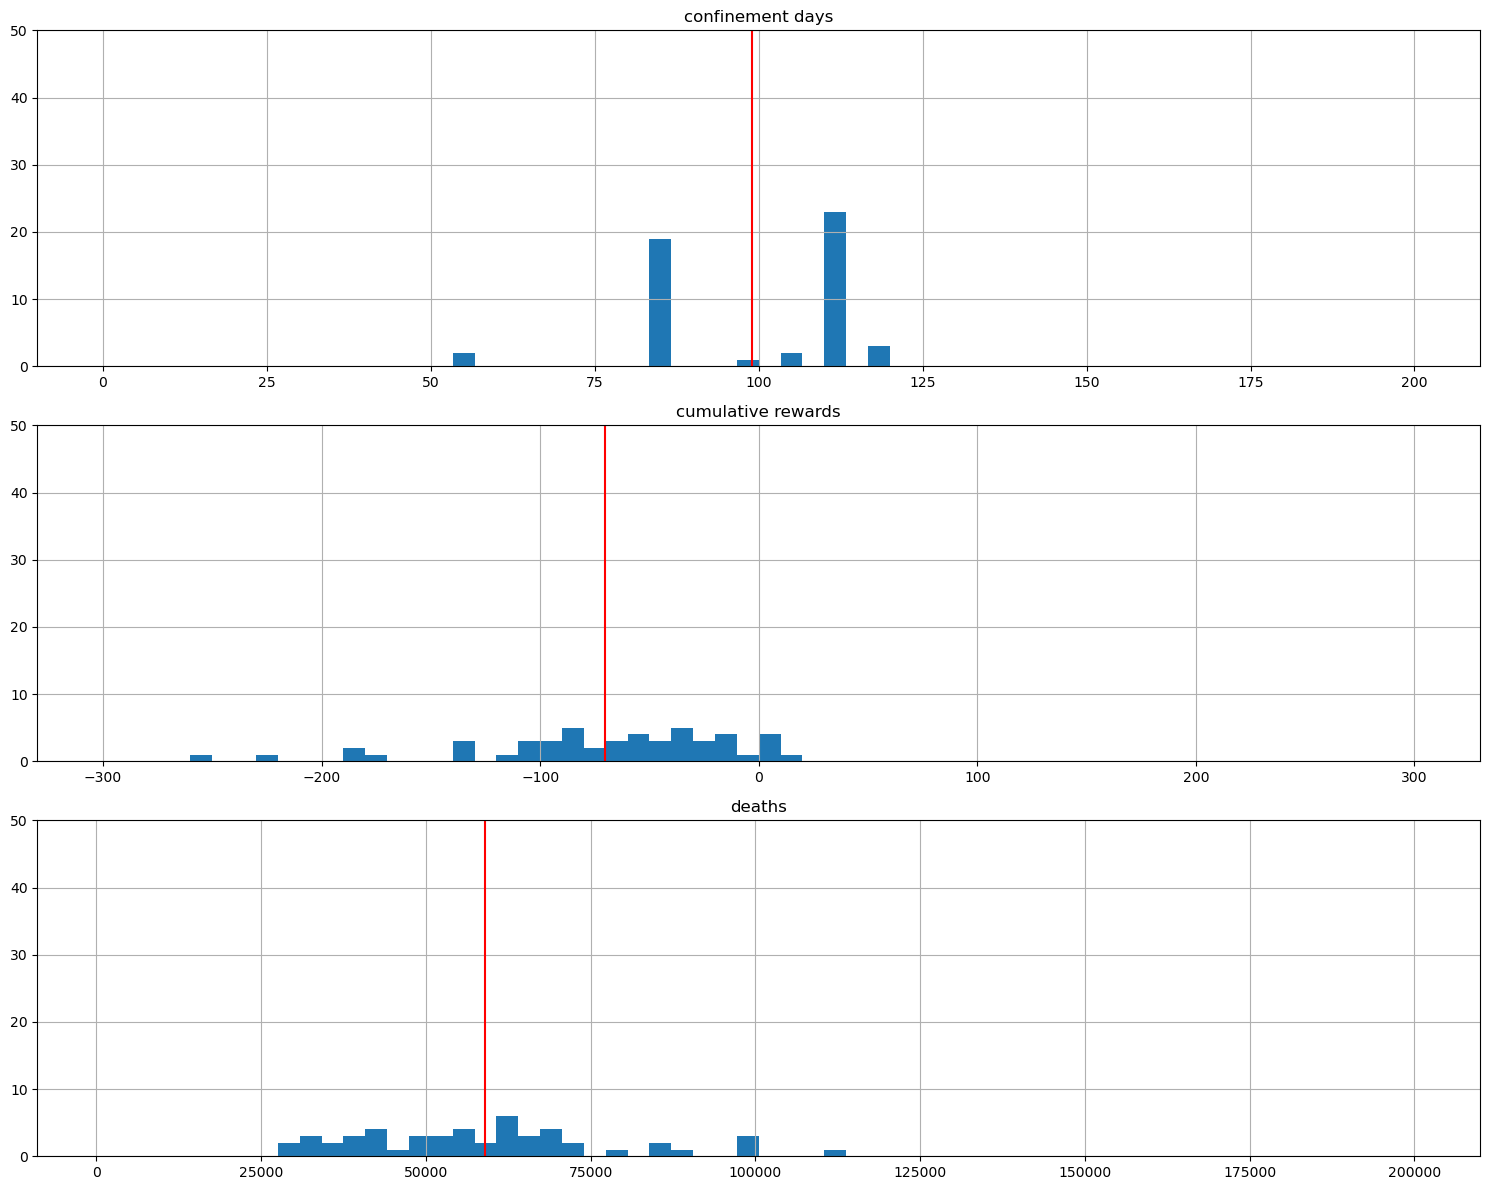

Average death: 58922.9
Average reward: -70.28965809565038
Average confined days: 98.98


In [81]:
"""Plot the histogram"""
plot_hist(log_confine, log_reward, log_death)

"""Print example of the log"""
print(f'Average death: {np.mean(log_death)}')
print(f'Average reward: {np.mean(log_reward)}')
print(f'Average confined days: {np.mean(log_confine)}')

## 3: A Deep Q-learning approach

### 3.1 Deep Q-Learning with a binary action space

#### Load libraries

In [82]:
'''Import libraries'''
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
import random
from collections import namedtuple, deque
from itertools import count
from gym import spaces
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

#### Initialize the environment and define action space and observation space

sampled space: 0
Sampled observation


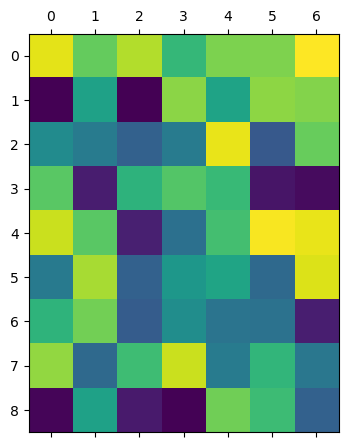

In [210]:
""" Define the action space and observation space """
dyn = ModelDynamics('config/switzerland.yaml')

action_space = spaces.Discrete(2) # 0: False, 1: True
observation_space = spaces.Box(low = 0,
                               high = 1,
                               shape = (2, dyn.n_cities,dyn.env_step_length),
                               dtype = np.float16)
print(f'sampled space: {action_space.sample()}')
print("Sampled observation")
plt.matshow(observation_space.sample()[1,:,:])
plt.show()

SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor,dyn: ModelDynamics):
    action = {
        'confinement': False,
        'isolation': False,
        'hospital': False,
        'vaccinate': False,
    }

    # Action tensor can only be 0 or 1 for Q3
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True

    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]),0.25)
    dead = SCALE * np.power(np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]),0.25)
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)
    

In [211]:
""" Initialze environment """
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

### Question 3a:  implementing Deep Q-Learning

#### Define neural network and agent's architecture

In [118]:
''' Define network architecture '''
class DQN(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        hidden_size1 = 64
        hidden_size2 = 32
        hidden_size3 = 16

        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = x.view(-1,self.input_size)
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x)) 
        x = torch.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [88]:
'''Utility function'''
def int_to_tensor(x, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    return torch.tensor(x, dtype=torch.float32, device=device).unsqueeze(0)

In [89]:
'''Define transition tuple'''
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


In [186]:
'''DQN agent architecture'''
class DQNAgent(Agent): 

    def __init__(self,  env:Env, epsilon:float = 0.7, batch_size: int = 2048, buffer_size: int = 20000, device = 'cuda', GAMMA : float = 0.9,
                 lr : float = 5e-3, policy_net = None, target_net = None, optimizer = None,
                # Additionnal parameters to be added here
                ):
        self.epsilon = epsilon
        self.env = env
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory_initial()
        self.device = device
        self.GAMMA = GAMMA
        self.lr = lr
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

    def save_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        torch.save(self.policy_net.state_dict(), savepath)
        pass

    def load_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        self.policy_net.load_state_dict(torch.load(savepath))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        pass

    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    # the action function for Q3a
    def act(self, obs, temp_epsilon):
        # write the epsilon-greedy policy here
        if random.random() < temp_epsilon:
            return int_to_tensor( self.env.action_space.sample()).unsqueeze(0) 
        else:
            return self.policy_net(obs.to(self.device)).max(1)[1].view(1, 1) # return the action with the highest q-value
    
    # the action functio for Q3b
    def act_decay(self, obs, epsilon0, epsilonmin, Tmax, t):
        temp_epsilon = np.max([epsilon0*(Tmax-t)/Tmax, epsilonmin])
        return self.act(obs, temp_epsilon)
        
    def memory_initial(self):
        # initialize the memory
        self.memory = deque([],maxlen= self.buffer_size) # define the memory as a deque of size capacity

    def memory_push(self, transition):
        # push a transition into the memory
        self.memory.append(transition)

    def memory_sample(self):
        # sample a batch from memory
        return random.sample(self.memory, self.batch_size)
    
    def memory_len(self):
        # return the length of the memory
        return len(self.memory)
    
    def optimize_model(self, train = True):
        # This is where one would define the optimization step of an RL algorithm
        if self.memory_len() < self.batch_size:
            return 0
        transitions = self.memory_sample()

        batch = Transition(*zip(*transitions)) # unzip the batch

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device= self.device, dtype=torch.bool).to(device)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)

        state_batch = torch.cat(batch.state).to(device)
        
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).squeeze().to(device)

        action_batch = action_batch.long()
        state_action_values = self.policy_net(state_batch).gather(1, action_batch).to(device)
        next_state_values = torch.zeros(self.batch_size, device= self.device)


        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values

        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
                
        criterion = nn.MSELoss() # define the loss function

        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        if train == True:
            # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100) 
            self.optimizer.step()
        return loss.item()
    
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [91]:
"""Utility functions used in training and evaluation"""

# Run one episode with fixed epsilon (0.7) and push the record into agent's memory, used for training
def each_episode(env, agent, seed):
    state, _ = env.reset(seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act(state, 0.7)
        next_state, reward, done, _ = env.step(action)
        agent.memory_push(Transition(state, action, next_state, reward))
        state = next_state
        total_reward += reward
        loss = agent.optimize_model()
        total_loss += loss

    return total_reward.item(), total_loss


# Run one episode with fixed epsilon (0), used for evaluation
def each_evaluation(env, agent, seed):
    state, _ = env.reset(seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act(state, 0)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        loss = agent.optimize_model(train = False)
        total_loss += loss

    return total_reward.item(), total_loss


#### Training

In [93]:
"""Initialization of training environment and agent"""
seed = 42
batch_size = 2048
lr = 5e-3
buffer_size = 20000
gamma = 0.9
input_size = 2 * dyn.n_cities * dyn.env_step_length

state, info = env.reset(seed)

# initialize policy network
policy_net = DQN(input_size,2).to(device)
target_net = DQN(input_size,2).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
dqnagent_3a = DQNAgent(env, epsilon=0.7, batch_size=batch_size, buffer_size=20000, GAMMA=gamma, lr = lr, device=device ,
                    policy_net=policy_net, target_net=target_net, optimizer=optimizer)

# number of episodes in training
n_episodes = 500

In [94]:
""" Define training function """
def train_3a(training_loss_trace_path = None,training_rewards_trace_path=  None, eval_loss_trace_path = None, eval_rewards_trace_path = None, experiment_id = None): 

    train_length:int = 500
    full_update: int = 5
    small_cycle: int = 50


    training_loss_trace = []
    training_rewards_trace = []
    eval_loss_trace = []
    eval_rewards_trace = []

    best_reward = -np.inf

    for i in range(1, train_length + 1):
        if i == 68: 
            print("pause")
        reward, loss = each_episode(env, dqnagent_3a, i)
        training_loss_trace.append(loss)
        training_rewards_trace.append(reward)
        print('Episode: ', i, '| Episode Reward: ', reward, '| Episode Loss: ', loss)
        if i % full_update == 0:
            # Fully update the target network every 5 episodes
            dqnagent_3a.update_target_model()
        
        if i % small_cycle == 0:
            eval_list = np.array([each_evaluation(env,dqnagent_3a,m) for m in range(20)])
            eval_loss = np.mean(eval_list,axis = 0)[1]
            eval_reward = np.mean(eval_list,axis = 0)[0]

            eval_loss_trace.append(eval_loss)
            eval_rewards_trace.append(eval_reward)
            training_loss = np.mean(training_loss_trace[i-50:i-1])
            training_reward = np.mean(training_rewards_trace[i-50:i-1])

            if eval_reward > best_reward:
                best_reward = eval_reward
                if experiment_id == None:
                    torch.save(dqnagent_3a.policy_net.state_dict(), '3a_dqnagent_best.pth')
                else:
                    torch.save(dqnagent_3a.policy_net.state_dict(), '3a_dqnagent_best_'+experiment_id+'.pth')
            # print episode i / training_length
            print(f'Episode {i} of {train_length}:train reward {training_reward:.2f}, train loss {training_loss:.4f}, eval reward {eval_reward:.2f},eval loss {eval_loss:.2f}')

    if training_loss_trace_path != None:
        with open(training_loss_trace_path, 'w') as f:
            json.dump(training_loss_trace, f)
    if training_rewards_trace_path != None:
        with open(training_rewards_trace_path, 'w') as f:
            json.dump(training_rewards_trace, f)
    if eval_loss_trace_path != None:
        with open(eval_loss_trace_path, 'w') as f:
            json.dump(eval_loss_trace, f)
    if eval_rewards_trace_path != None:
        with open(eval_rewards_trace_path, 'w') as f:
            json.dump(eval_rewards_trace, f)

    return training_loss_trace,training_rewards_trace,eval_loss_trace,eval_rewards_trace
    

In [ ]:
""" Perform multiple experiments and save the traces """
n_experiments = 3
training_loss_trace_combine = []
training_rewards_trace_combine = []
eval_loss_trace_combine = []
eval_rewards_trace_combine = []


for i in range(n_experiments):
    # Macros
    seed = 42
    batch_size = 2048
    lr = 5e-3
    buffer_size = 20000
    gamma = 0.9
    input_size = 2 * dyn.n_cities * dyn.env_step_length

    state, info = env.reset(seed)

    # initialize agents
    policy_net = DQN(input_size,2).to(device)
    target_net = DQN(input_size,2).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    dqnagent_3a = DQNAgent(env, gamma = gamma, policy_net = policy_net, target_net = target_net, optimizer = optimizer, device = device, epsilon=0.7)

    print(f'=====================================Experiment {i+1} of {n_experiments}================================')
    tl,tr,el,er = train_3a(experiment_id = i, training_loss_trace_path = f'./Q3a_json/Q3a_train_loss_{i}.json',training_rewards_trace_path= f'./Q3a_json/Q3a_train_reward_{i}.json', eval_loss_trace_path = f'./Q3a_json/Q3a_eval_loss_{i}.json', eval_rewards_trace_path = f'./Q3a_json/Q3a_eval_reward_{i}.json')

    # Save traces in lists
    training_loss_trace_combine.append(tl)
    training_rewards_trace_combine.append(tr)
    eval_loss_trace_combine.append(el)
    eval_rewards_trace_combine.append(er)
print("=====================================Experiment Done================================")

#### Evaluation

In [65]:
""" Function for reading and plotting the saved traces"""
import pandas as pd
import seaborn as sns

def plot_trace(stage: str, name: str, plot_individual_reward = False):
    # Load traces and combine json into a dataframe
    with open(stage + '_json/' + stage +'_train_reward_1.json') as f:
        data1 = json.load(f)
        data1 = pd.DataFrame(data1)
        data1.columns = [ 'train reward 1']
    with open(stage + '_json/' + stage +'_train_reward_2.json') as f:
        data2 = json.load(f)
        data2 = pd.DataFrame(data2)
        data2.columns = [ 'train reward 2']
    with open(stage + '_json/' + stage +'_train_reward_3.json') as f:
        data3 = json.load(f)
        data3 = pd.DataFrame(data3)
        data3.columns = ['train reward 3']
    
    # get train data
    data = pd.concat([data1, data2, data3],axis=1)
    train_data = data.reset_index()
    train_data.columns = ['episode', 'train reward 1', 'train reward 2', 'train reward 3']

    with open(stage + '_json/' + stage +'_eval_reward_1.json') as f:
        data1 = json.load(f)
        data1 = pd.DataFrame(data1)
        data1.columns = [ 'eval reward 1']
    with open(stage + '_json/' + stage +'_eval_reward_2.json') as f:
        data2 = json.load(f)
        data2 = pd.DataFrame(data2)
        data2.columns = [ 'eval reward 1']
    with open(stage + '_json/' + stage +'_eval_reward_3.json') as f:
        data3 = json.load(f)
        data3 = pd.DataFrame(data3)
        data3.columns = ['eval reward 1']

    # get test data
    data = pd.concat([data1, data2, data3],axis=1)
    test_data = data.apply(lambda x: x.mean(), axis=1)

    test_data = test_data.reset_index()

    test_data.columns = ['episode', 'reward']
    test_data['episode'] = (test_data['episode'] + 1)*50


    # plot the scatter plot and line plot

    plt.figure(figsize=(6, 4),dpi = 100)
    sns.scatterplot(data=train_data[['train reward 1','train reward 2','train reward 3']],  alpha=0.3, s = 10)
    sns.lineplot(x='episode', y='reward', data=test_data, color='blue', markers=True, dashes=False,label = 'avg. eval reward')

    # whether to plot individual training process

    if(plot_individual_reward):
        new_data = data.reset_index()
        new_data.columns = ['episode', 'eval reward 1', 'eval reward 2', 'eval reward 3']
        new_data['episode'] = (new_data['episode'] + 1)*50
        sns.lineplot(x='episode', y='eval reward 1', data=new_data[['episode','eval reward 1']], color='red',alpha = 0.4, markers=True, dashes=False,label = 'eval reward 1')
        sns.lineplot(x='episode', y='eval reward 2', data=new_data[['episode','eval reward 2']], color='yellow',alpha = 0.4, markers=True, dashes=False,label = 'eval reward 2')
        sns.lineplot(x='episode', y='eval reward 3', data=new_data[['episode','eval reward 3']], color='green',alpha = 0.4, markers=True, dashes=False,label = 'eval reward 3')
    
    # mark the maximum value of the lineplot

    plt.plot(test_data['episode'][test_data['reward'].idxmax()], test_data['reward'].max(), 'bx')

    # lable the maximum value with red color of the lineplot using red color

    plt.text(test_data['episode'][test_data['reward'].idxmax()]-154, test_data['reward'].max()+10, 'Max reward = {}'.format(round(test_data['reward'].max(), 1)), color='blue')


    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.xlim(0, 500)
    plt.ylim(-300, 100)
    plt.legend(loc='lower right')
    # plot a base line for y = 0
    plt.plot([0, 500], [0, 0], 'k--')

    plt.title(name + ' train & eval reward trace')
    plt.show()

In [101]:
""" Function for plotting an episode"""
def test_episode_and_plot(agent, seed:int):
    log2 = []
    finished = False
    obs, info = env.reset(seed)
    while not finished:
        action = agent.act(obs,0)
        obs, R, finished, info = env.step(action)
        log2.append(info) # save the information dict for logging
        if finished:
            break

    plot(log2)

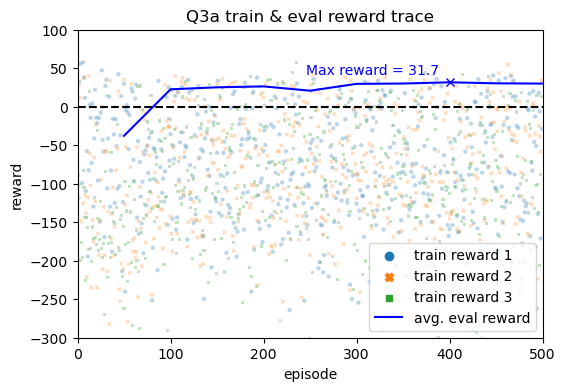

In [66]:
""" Plot rewards trace """
plot_trace('Q3a','Q3a', False)

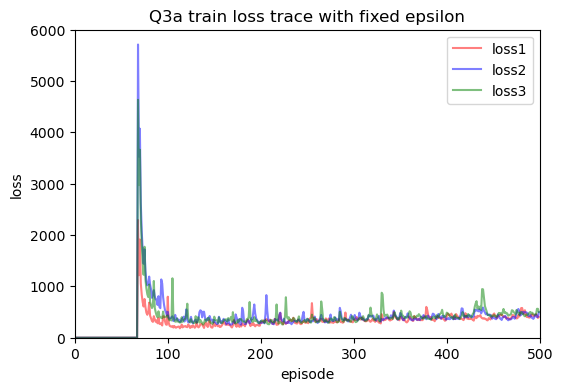

In [201]:
""" Plot loss trace """

# Load trace files
with open('Q3a_json/Q3a_train_loss_1.json') as f:
    data1 = json.load(f)
    data1 = pd.DataFrame(data1)
    data1.columns = [ 'loss1']
with open('Q3a_json/Q3a_train_loss_2.json') as f:
    data2 = json.load(f)
    data2 = pd.DataFrame(data2)
    data2.columns = [ 'loss2']
with open('Q3a_json/Q3a_train_loss_3.json') as f:
    data3 = json.load(f)
    data3 = pd.DataFrame(data3)
    data3.columns = ['loss3']
data = pd.concat([data1, data2, data3],axis=1)
train_data = data.reset_index()
train_data.columns = ['episode', 'loss1', 'loss2', 'loss3']

# plot a lineplot of train loss
plt.figure(figsize=(6, 4),dpi = 100)
sns.lineplot(x='episode', y='loss1', data=train_data, color='red', markers=True, dashes=False,label = 'loss1',alpha = 0.5)
sns.lineplot(x='episode', y='loss2', data=train_data, color='blue', markers=True, dashes=False,label = 'loss2',alpha = 0.5)
sns.lineplot(x='episode', y='loss3', data=train_data, color='green', markers=True, dashes=False,label = 'loss3',alpha = 0.5)


plt.xlabel('episode')
plt.ylabel('loss')
plt.xlim(0, 500)
plt.ylim(0, 6000)
plt.legend(loc='upper right')
plt.title('Q3a train loss trace with fixed epsilon')
plt.show()

In [202]:
""" initialize agent and load the saved weight"""
policy_net = DQN(input_size,2).to(device)
target_net = DQN(input_size,2).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
DQNagent = DQNAgent(env, GAMMA = gamma, epsilon= 0.7, policy_net = policy_net, target_net = target_net, device = device,optimizer=optimizer)

# Read from saved weights
DQNagent.load_model("DQN_best_Q3a_all.pth")

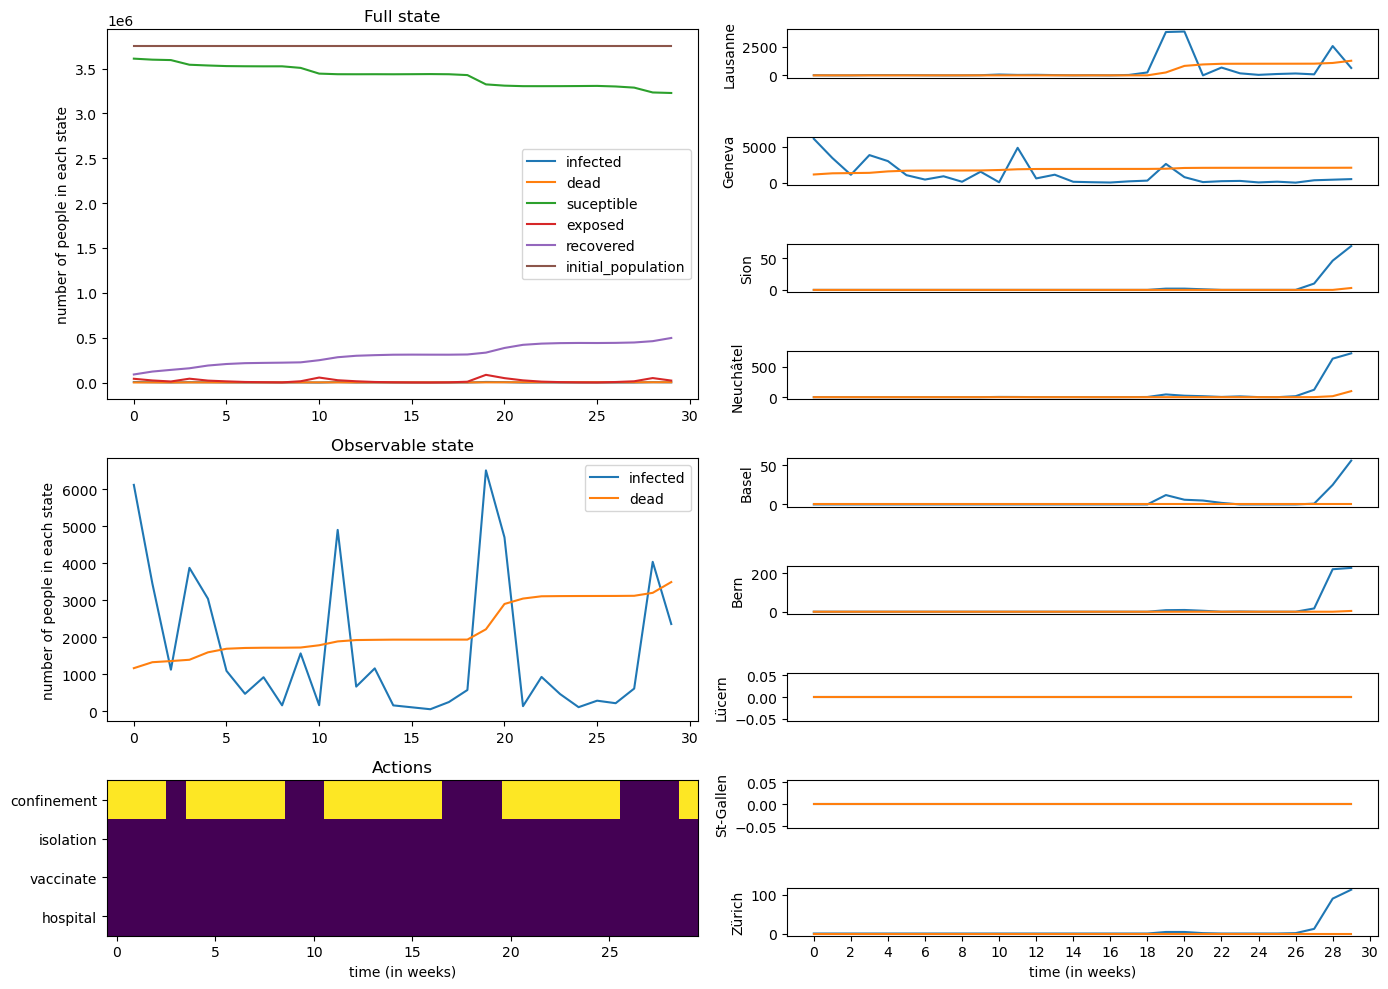

In [203]:
""" Plot one episode with seed 1 """
test_episode_and_plot(DQNagent, 1)

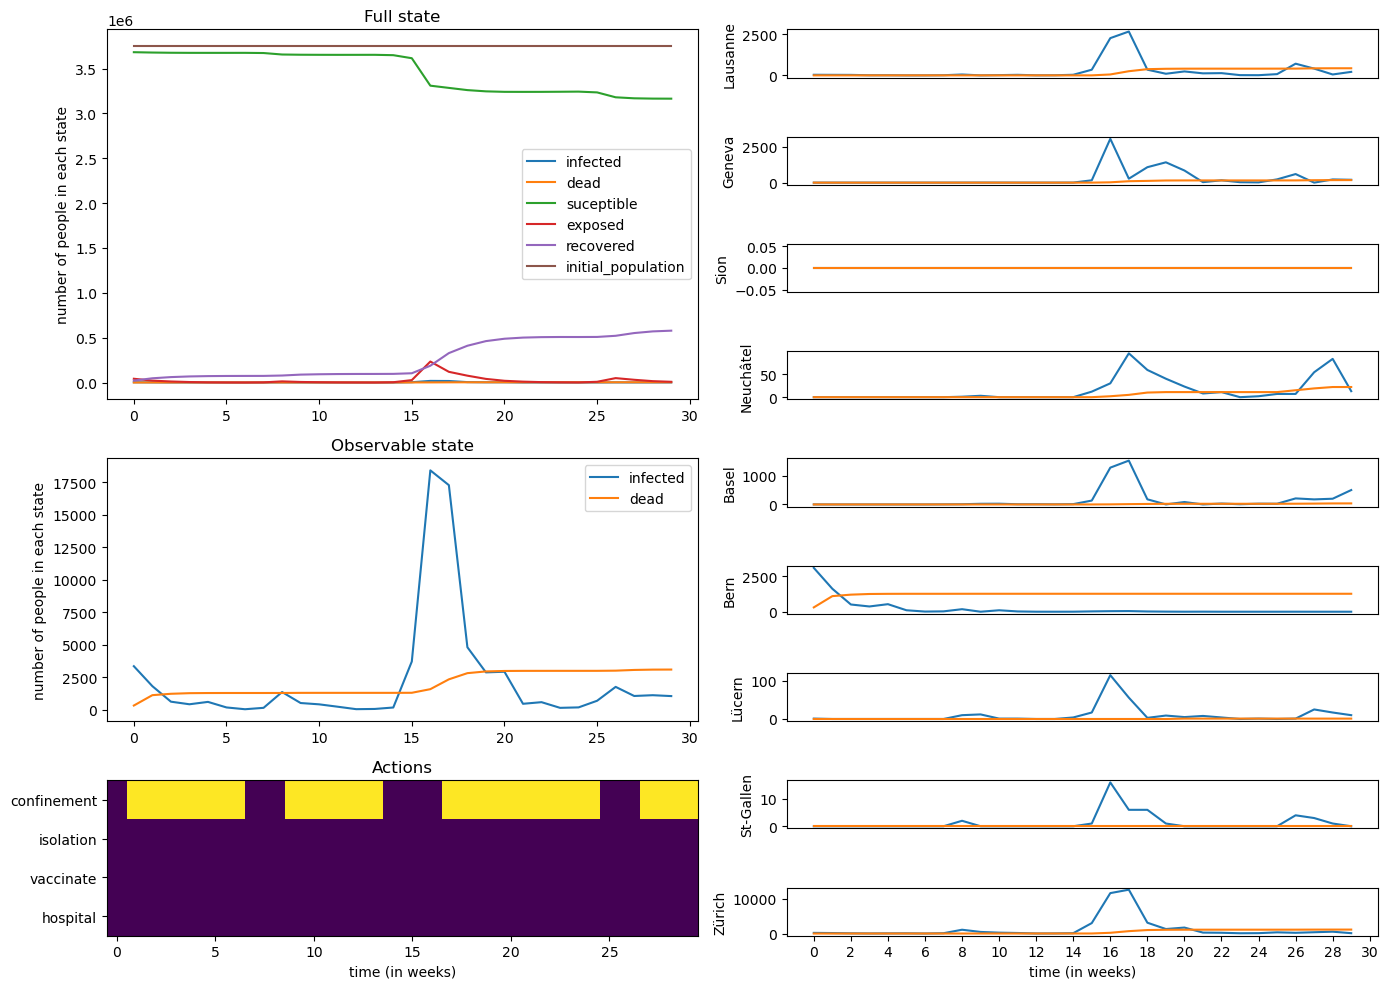

In [204]:
""" Plot one episode with seed 5 """
test_episode_and_plot(DQNagent, 5)

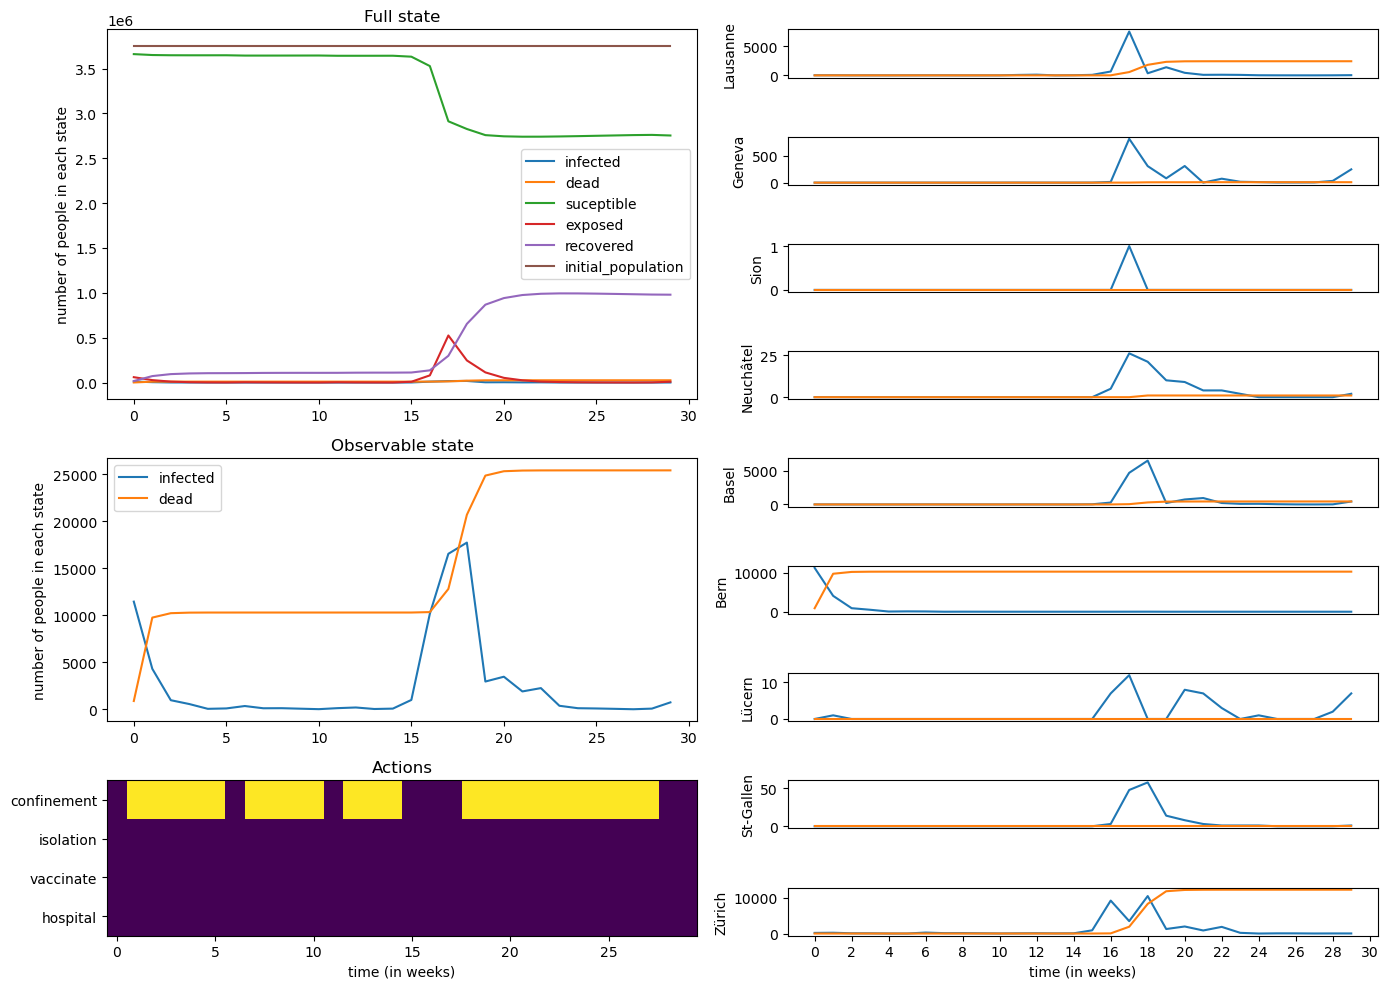

In [205]:
""" Plot one episode with seed 42 """
test_episode_and_plot(DQNagent, 42)

### Question 3b:  decreasing exploration

In [105]:
""" Define function performing epsilon decay exploration"""
def one_episode_decay(env,agent,random_seed, epsilon0, epsilonmin, Tmax, t):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act_decay(state, epsilon0, epsilonmin, Tmax, t)
        next_state, reward, done, _ = env.step(action)
        agent.memory_push(Transition(state, action, next_state, reward))
        state = next_state
        total_reward += reward
        loss = agent.optimize_model()
        total_loss += loss
    
    return total_reward.item(), total_loss

In [112]:
""" Training function for Q3b """
def train_Q3b(experiment_id):
    print(f"Experiment {experiment_id}")
    print('-------------------------------------------')

    # Initialize policy and target network
    policy_net = DQN(input_dim, 2).to(device)
    target_net = DQN(input_dim, 2).to(device)
    # Initialize the target network to be the same as the policy network
    target_net.load_state_dict(policy_net.state_dict()) 


    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    DQNagentb = DQNAgent(env, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                    policy_net=policy_net, target_net=target_net, optimizer=optimizer)

    train_loss_trace = []
    train_reward_trace = []
    eval_loss_trace = []
    eval_reward_trace = []

    best = -np.inf

    for i in range(1,501):
        reward, loss = one_episode_decay(env,DQNagentb,i,0.7,0.2,500,i)
        train_loss_trace.append(loss)
        train_reward_trace.append(reward)
        #print(f"Episode {i} : reward {reward}, loss {loss}")
        if i % 5 == 0:
            DQNagentb.update_target_model()
        if i % 50 == 0 :
            #testlist = random.sample(range(100), 20) 
            tuple_list = np.array([eval_one(env,DQNagentb,m) for m in range(20)])
            eval_losss = np.mean(tuple_list,axis = 0)[1]
            eval_rewards = np.mean(tuple_list,axis = 0)[0]

            eval_loss_trace.append(eval_losss)
            eval_reward_trace.append(eval_rewards)
            train_loss = np.mean(train_loss_trace[i-50:i-1])
            train_reward = np.mean(train_reward_trace[i-50:i-1])
            
            if eval_rewards > best:
                best = eval_rewards
                #torch.save(DQNagentb.policy_net.state_dict(), "DQN_best_Q3b.pth")
                torch.save(DQNagent.policy_net.state_dict(), f"DQN_best_Q3b_{experiment_id}.pth")   
            print(f"Episode {i} : train_reward {train_reward}, train_loss {train_loss}")
            print(f"Episode {i} : eval_reward {eval_rewards}, eval_loss {eval_losss}")

    # record the train_loss trace in corresponding experiment_id
    with open(f'.Q3b_json/Q3b_train_loss_{experiment_id}.json', 'w') as f: json.dump(train_loss_trace, f)
    with open(f'.Q3b_json/Q3b_train_reward_{experiment_id}.json', 'w') as f: json.dump(train_reward_trace, f)
    with open(f'.Q3b_json/Q3b_eval_loss_{experiment_id}.json', 'w') as f: json.dump(eval_loss_trace, f)
    with open(f'.Q3b_json/Q3b_eval_reward_{experiment_id}.json', 'w') as f: json.dump(eval_reward_trace, f)

In [206]:
""" Define training macros"""
seed = 42
BATCH_SIZE = 2048
LR = 5e-3
BATCH_SIZE = 20000
GAMMA = 0.9
input_dim = 2 * dyn.n_cities * dyn.env_step_length

In [ ]:
""" Experiment for 3 runs """
for i in range(1,4):
    train_Q3b(i)

#### Evaluation

In [176]:
""" Define statistic function """
def get_statistics(agent):
    deaths_list, rewards_list, conf_days = [],[],[]
 
    for i in range(50):
        total_deaths = 0
        total_rewards = 0
        total_conf = 0
        
        finished = False
        obs, info = env.reset(i)

  
        while not finished:
            action = agent.act(obs,0)
            #print(action.item())
            if action.item() == 1: total_conf += 7
            obs, R, finished, info = env.step(action)
            
            total_rewards += float(R)
            if finished:
                deaths_list.append(info.total.dead)
                break
        
        conf_days.append(total_conf)
        rewards_list.append(total_rewards)

    return deaths_list, rewards_list, conf_days

In [183]:
""" Load trained weights """
policy_net = DQN(input_dim, 2).to(device)
target_net = DQN(input_dim, 2).to(device)
# Initialize the target network to be the same as the policy network
target_net.load_state_dict(policy_net.state_dict()) 


optimizer = optim.Adam(policy_net.parameters(), lr=LR)
DQNagentb = DQNAgent(env, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                policy_net=policy_net, target_net=target_net, optimizer=optimizer)

DQNagentb.load_model("DQN_best_Q3b_all.pth")

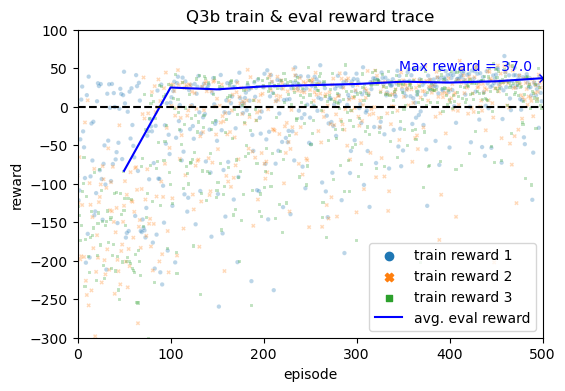

In [107]:
""" Plot rewards trace """
plot_trace('Q3b','Q3b', False)

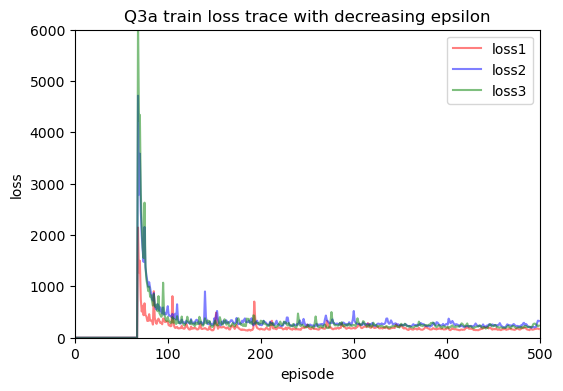

In [207]:
""" Plot loss trace """
# Read saved traces as pandas dataframe
with open('Q3b_json/Q3b_train_loss_1.json') as f:
    data1 = json.load(f)
    data1 = pd.DataFrame(data1)
    data1.columns = [ 'loss1']
with open('Q3b_json/Q3b_train_loss_2.json') as f:
    data2 = json.load(f)
    data2 = pd.DataFrame(data2)
    data2.columns = [ 'loss2']
with open('Q3b_json/Q3b_train_loss_3.json') as f:
    data3 = json.load(f)
    data3 = pd.DataFrame(data3)
    data3.columns = ['loss3']
data = pd.concat([data1, data2, data3],axis=1)
train_data = data.reset_index()
train_data.columns = ['episode', 'loss1', 'loss2', 'loss3']

# plot a lineplot of train loss
plt.figure(figsize=(6, 4),dpi = 100)
sns.lineplot(x='episode', y='loss1', data=train_data, color='red', markers=True, dashes=False,label = 'loss1',alpha = 0.5)
sns.lineplot(x='episode', y='loss2', data=train_data, color='blue', markers=True, dashes=False,label = 'loss2',alpha = 0.5)
sns.lineplot(x='episode', y='loss3', data=train_data, color='green', markers=True, dashes=False,label = 'loss3',alpha = 0.5)

plt.xlabel('episode')
plt.ylabel('loss')
plt.xlim(0, 500)
plt.ylim(0, 6000)
plt.legend(loc='upper right')
plt.title('Q3a train loss trace with decreasing epsilon')
plt.show()

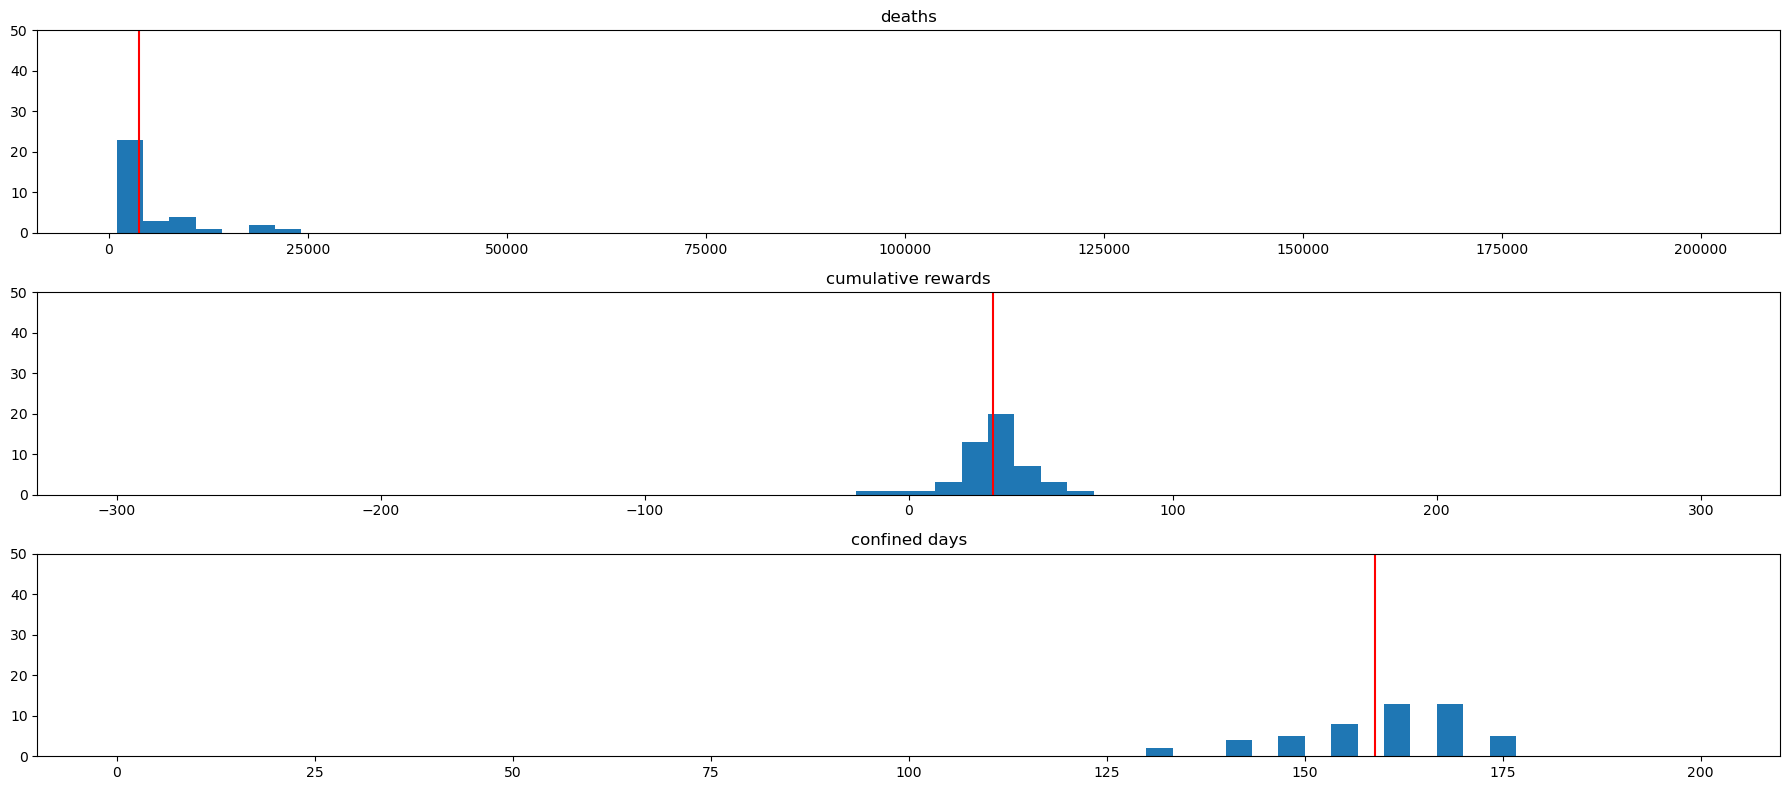

Average death number: 3812.86
Average number of confined days: 158.9
Average cumulative reward: 32.061366457156836


In [184]:
""" Plot histogram """
deaths, rewards, conf_days  = get_statistics(DQNagentb)

fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')

fig.tight_layout()
plt.show()

""" Print statistics """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')

## 4: Dealing with a more complex action Space

### 4.1 Toggle-action-space multi-action agent

sampled action : 0
Sampled observation


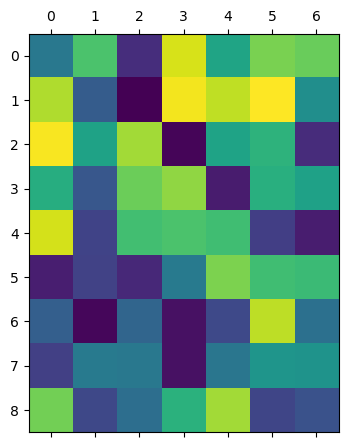

In [121]:
""" Re-design the action space and observation space """
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[1,:,:])
plt.show()

SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

def action_preprocessor_m(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': bool(dyn.get_action()['confinement']), 
        'isolation': bool(dyn.get_action()['isolation']), 
        'hospital': bool(dyn.get_action()['hospital']), 
        'vaccinate': bool(dyn.get_action()['vaccinate']),
    }
    
    # if action is not none, the corresponding previous action will be reversed
    if a == ACTION_CONFINE:
        action['confinement'] = bool( 1 - dyn.get_action()['confinement'] ) 
    elif a == ACTION_ISOLATE:
        action['isolation'] = bool( 1 - dyn.get_action()['isolation'] )
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = bool( 1 - dyn.get_action()['vaccinate'] )
    elif a == ACTION_HOSPITAL:
        action['hospital'] = bool( 1 - dyn.get_action()['hospital'] )
        
    return action

def observation_preprocessor_m(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 0.25)
    dead = SCALE * np.power( np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 0.25)
    
    # added observation for previous actions
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    isolationed = np.ones_like(dead)*int((dyn.get_action()['isolation']))
    hospitaled = np.ones_like(dead)*int((dyn.get_action()['hospital']))
    vaccinated = np.ones_like(dead)*int((dyn.get_action()['vaccinate']))

    return torch.Tensor(np.stack((infected, dead, confined, isolationed, hospitaled, vaccinated))).unsqueeze(0)

In [122]:
"""initialize a new environment"""
env_m = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_m,
            observation_preprocessor=observation_preprocessor_m,
            )

In [127]:
""" Define multi action toggle action agent """
class DQNAgentMultiToggle(Agent):
    def __init__(self,  env:Env, epsilon:float = 0.7, batch_size: int = 2048, buffer_size: int = 20000, device = 'cuda', GAMMA : float = 0.9,
                 lr : float = 1e-5, policy_net = None, target_net = None, optimizer = None,
                # Additionnal parameters to be added here
                ):
        self.epsilon = epsilon
        self.env = env
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory_initial()
        self.device = device
        self.GAMMA = GAMMA
        self.lr = lr
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

    def save_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        torch.save(self.policy_net.state_dict(), savepath)
        pass

    def load_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        self.policy_net.load_state_dict(torch.load(savepath))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        pass

    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    # the action function for Q3a
    def act(self, obs, temp_epsilon):
        # write the epsilon-greedy policy here
        if random.random() < temp_epsilon:
            return int_to_tensor( self.env.action_space.sample()).unsqueeze(0) 
        else:
            m = self.policy_net(obs.to(self.device)).max(1)[1].view(1, 1)
            return m # return the action with the highest q-value
    
    # the action functio for Q3b
    def act_decay(self, obs, epsilon0, epsilonmin, Tmax, t):
        temp_epsilon = np.max([epsilon0*(Tmax-t)/Tmax, epsilonmin])
        return self.act(obs, temp_epsilon)
        
    def memory_initial(self):
        # initialize the memory
        self.memory = deque([],maxlen= self.buffer_size) # define the memory as a deque of size capacity

    def memory_push(self, transition):
        # push a transition into the memory
        self.memory.append(transition)

    def memory_sample(self):
        # sample a batch from memory
        return random.sample(self.memory, self.batch_size)
    
    def memory_len(self):
        # return the length of the memory
        return len(self.memory)
    
    def optimize_model(self, train = True):
        # This is where one would define the optimization step of an RL algorithm
        if self.memory_len() < self.batch_size:
            return 0
        transitions = self.memory_sample()

        batch = Transition(*zip(*transitions)) # unzip the batch

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device= self.device, dtype=torch.bool).to(device)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)

        state_batch = torch.cat(batch.state).to(device)
        
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).squeeze().to(device)

        action_batch = action_batch.long()
        state_action_values = self.policy_net(state_batch).gather(1, action_batch).to(device)
        next_state_values = torch.zeros(self.batch_size, device= self.device)


        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values

        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
                
        criterion = nn.MSELoss() # define the loss function

        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        if train == True:
            # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100) 
            self.optimizer.step()
        return loss.item()
    
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

### Question 4.1.b: Toggle-action-space multi-action policy training

In [125]:
""" Macros """
random_seed = 42 
BATCH_SIZE = 2048
GAMMA = 0.9
LR = 1e-3 # switch between 1e-3 and 1e-5
input_dim = 6 * dyn.n_cities * dyn.env_step_length

In [128]:
""" Define training function """
def train_Q4a(experiment_id):
    #print(experiment id)
    print(f"Experiment {experiment_id}")
    print('-------------------------------------------')

    input_dim = 6 * dyn.n_cities * dyn.env_step_length
    # Initialize policy and target network
    policy_net = DQN(input_dim, 5).to(device)
    target_net = DQN(input_dim, 5).to(device)
    # Initialize the target network to be the same as the policy network
    target_net.load_state_dict(policy_net.state_dict()) 

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    DQNagent = DQNAgentMultiToggle(env_m, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                        policy_net=policy_net, target_net=target_net, optimizer=optimizer)

    train_loss_trace = []
    train_reward_trace = []
    eval_loss_trace = []
    eval_reward_trace = []

    best = -np.inf

    for i in range(1,501):
        reward, loss = one_episode_decay(env_m,DQNagent,i,0.7,0.2,500,i)
        train_loss_trace.append(loss)
        train_reward_trace.append(reward)
        #print(f"Episode {i} : reward {reward}, loss {loss}")
        if i % 5 == 0:
            DQNagent.update_target_model()
        if i % 50 == 0 :
         
            tuple_list = np.array([eval_one(env_m,DQNagent,m) for m in range(20)])
            eval_losss = np.mean(tuple_list,axis = 0)[1]
            eval_rewards = np.mean(tuple_list,axis = 0)[0]

            eval_loss_trace.append(eval_losss)
            eval_reward_trace.append(eval_rewards)
            train_loss = np.mean(train_loss_trace[i-50:i-1])
            train_reward = np.mean(train_reward_trace[i-50:i-1])
            
            if eval_rewards > best:
                best = eval_rewards
                # save the model in this experiment_id
                torch.save(DQNagent.policy_net.state_dict(), f"DQN_best_Q4a_{experiment_id}.pth")   
            print(f"Episode {i} : train_reward {train_reward}, train_loss {train_loss}")
            print(f"Episode {i} : eval_reward {eval_rewards}, eval_loss {eval_losss}")

    # record the train_loss trace in corresponding experiment_id
    with open(f'Q4a_train_loss_{experiment_id}.json', 'w') as f: json.dump(train_loss_trace, f)
    with open(f'Q4a_train_reward_{experiment_id}.json', 'w') as f: json.dump(train_reward_trace, f)
    with open(f'Q4a_eval_loss_{experiment_id}.json', 'w') as f: json.dump(eval_loss_trace, f)
    with open(f'Q4a_eval_reward_{experiment_id}.json', 'w') as f: json.dump(eval_reward_trace, f)

In [131]:
""" Define epsilon decay episodal training function and evaluation function """
def one_episode_decay(env,agent,random_seed, epsilon0, epsilonmin, Tmax, t):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act_decay(state, epsilon0, epsilonmin, Tmax, t)
        next_state, reward, done, _ = env.step(action)
        agent.memory_push(Transition(state, action, next_state, reward))
        state = next_state
        total_reward += reward
        loss = agent.optimize_model()
        total_loss += loss
    
    return total_reward.item(), total_loss


def eval_one(env,agent, random_seed):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act(state,0)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        loss = agent.optimize_model(train = False)
        total_loss += loss
    
    return total_reward.item(), total_loss


In [ ]:
""" Perform experiments """
for i in range(1,4):
    train_Q4a(i)

In [133]:
""" Load trained model """
# Initialize policy and target network
policy_net = DQN(input_dim, 5).to(device)
target_net = DQN(input_dim, 5).to(device)
# Initialize the target network to be the same as the policy network
target_net.load_state_dict(policy_net.state_dict()) 

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
DQNagent = DQNAgentMultiToggle(env_m, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                    policy_net=policy_net, target_net=target_net, optimizer=optimizer)

DQNagent.load_model('DQN_best_Q4a_all.pth')

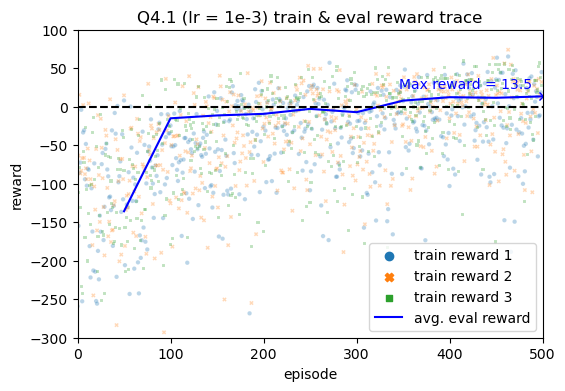

In [137]:
""" Plot traces recored at the learning rate of 1e-3 """
plot_trace('Q4','Q4.1 (lr = 1e-3)', False)

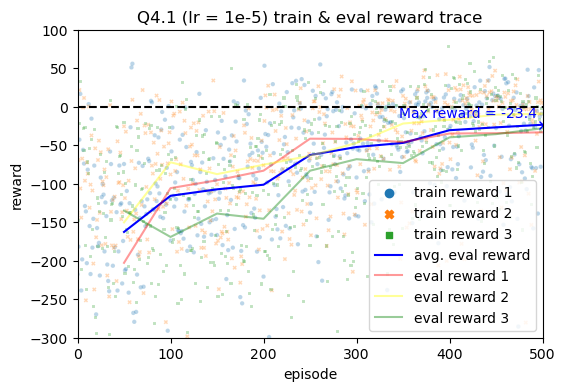

In [216]:
""" Plot traces recored at the learning rate of 1e-5 """
plot_trace('Q4_5','Q4.1 (lr = 1e-5)', True)

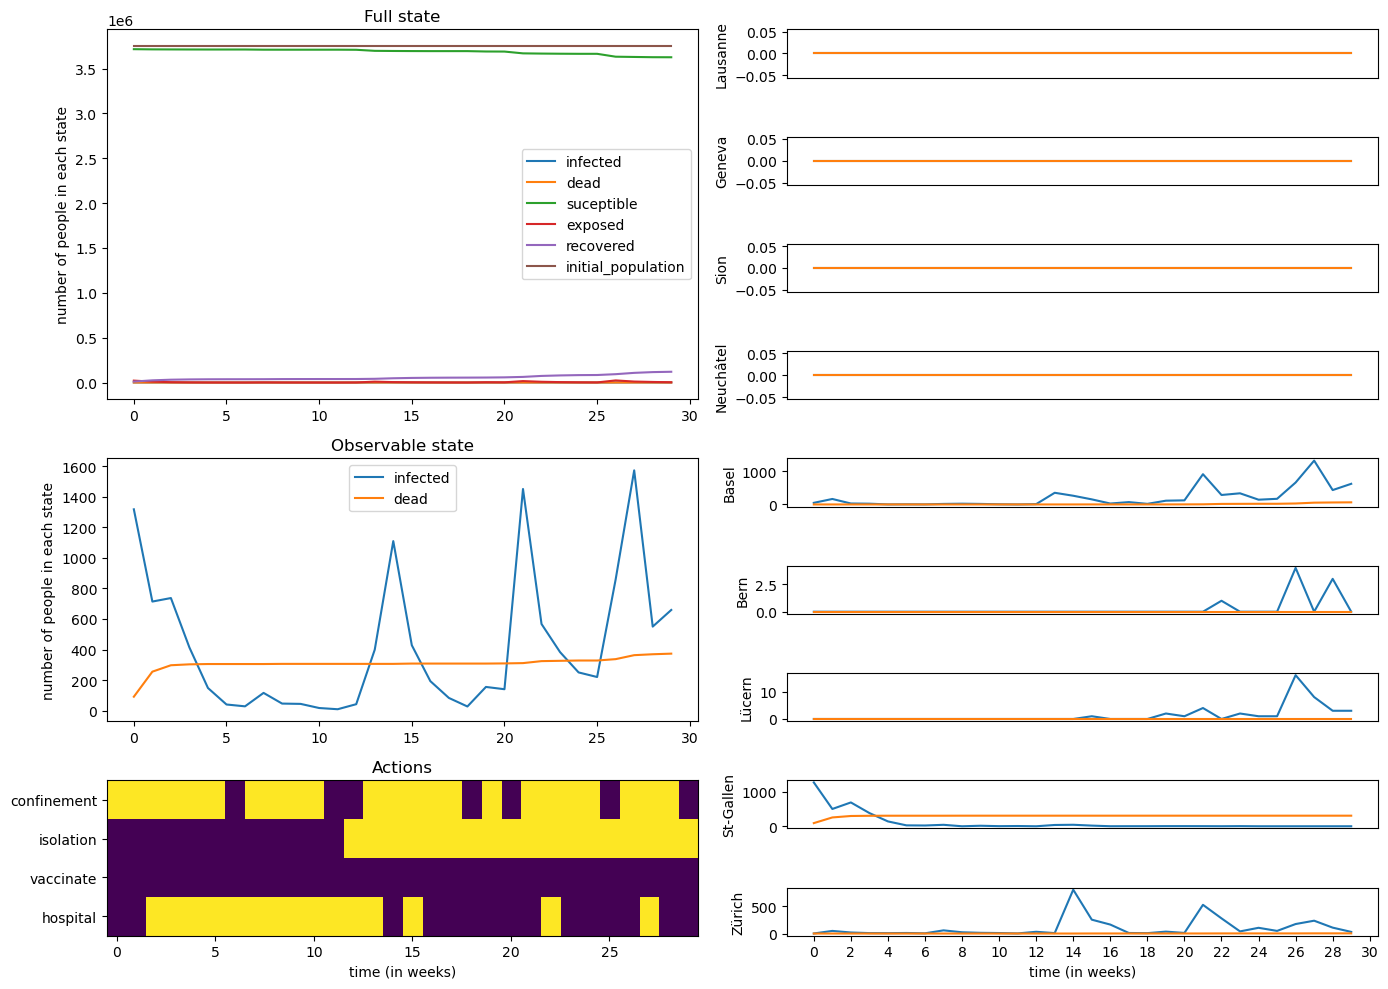

In [135]:
""" Run one episode """
log2 = []
finished = False
obs, info = env_m.reset(0)

while not finished:
    action = DQNagent.act(obs,0)
    obs, R, finished, info = env_m.step(action)
    log2.append(info) # save the information dict for logging
    if finished:
        break

plot(log2)

### Question 4.1.c: Toggle-action-space multi-action policy evaluation

In [138]:
""" Define statistic function """
# this function runs 50 episodes and gather deaths rewards and total days of different actions
def get_statistics(env, agent):
    deaths_list, rewards_list, conf_days, isol_days, hosp_days, vacc_days = [],[],[],[],[],[]
    
    # Seeds for environment
    seeds = range(50)
    for i in range(50):
        total_deaths = 0
        total_rewards = 0
        total_conf = 0
        total_isol = 0
        total_hosp = 0
        total_vacc = 0
        
        finished = False
        obs, info = env.reset(seeds[i])

        confine = False
        isolate = False
        hospital = False
        vaccinate = False
  
        while not finished:
            action = agent.act(obs,0)
            
            # Interpret action and record it
            if action.item() == 0:
                pass
            if action.item() == ACTION_CONFINE:
                confine = bool(1 - int(confine))
            if action.item() == ACTION_ISOLATE:
                isolate = bool(1 - int(isolate))
            if action.item() == ACTION_HOSPITAL:
                hospital = bool(1 - int(hospital))
            if action.item() == ACTION_VACCINATE:
                vaccinate = bool(1 - int(vaccinate))

            total_conf += confine * 7
            total_isol += isolate * 7
            total_hosp += hospital * 7
            total_vacc += vaccinate * 7

            obs, R, finished, info = env.step(action)
            
            total_rewards += float(R)
            if finished:
                deaths_list.append(info.total.dead)
                break
        
        # Make lists
        conf_days.append(total_conf)
        isol_days.append(total_isol)
        hosp_days.append(total_hosp)
        vacc_days.append(total_vacc)
        rewards_list.append(total_rewards)

    return deaths_list, rewards_list, conf_days,isol_days,hosp_days,vacc_days

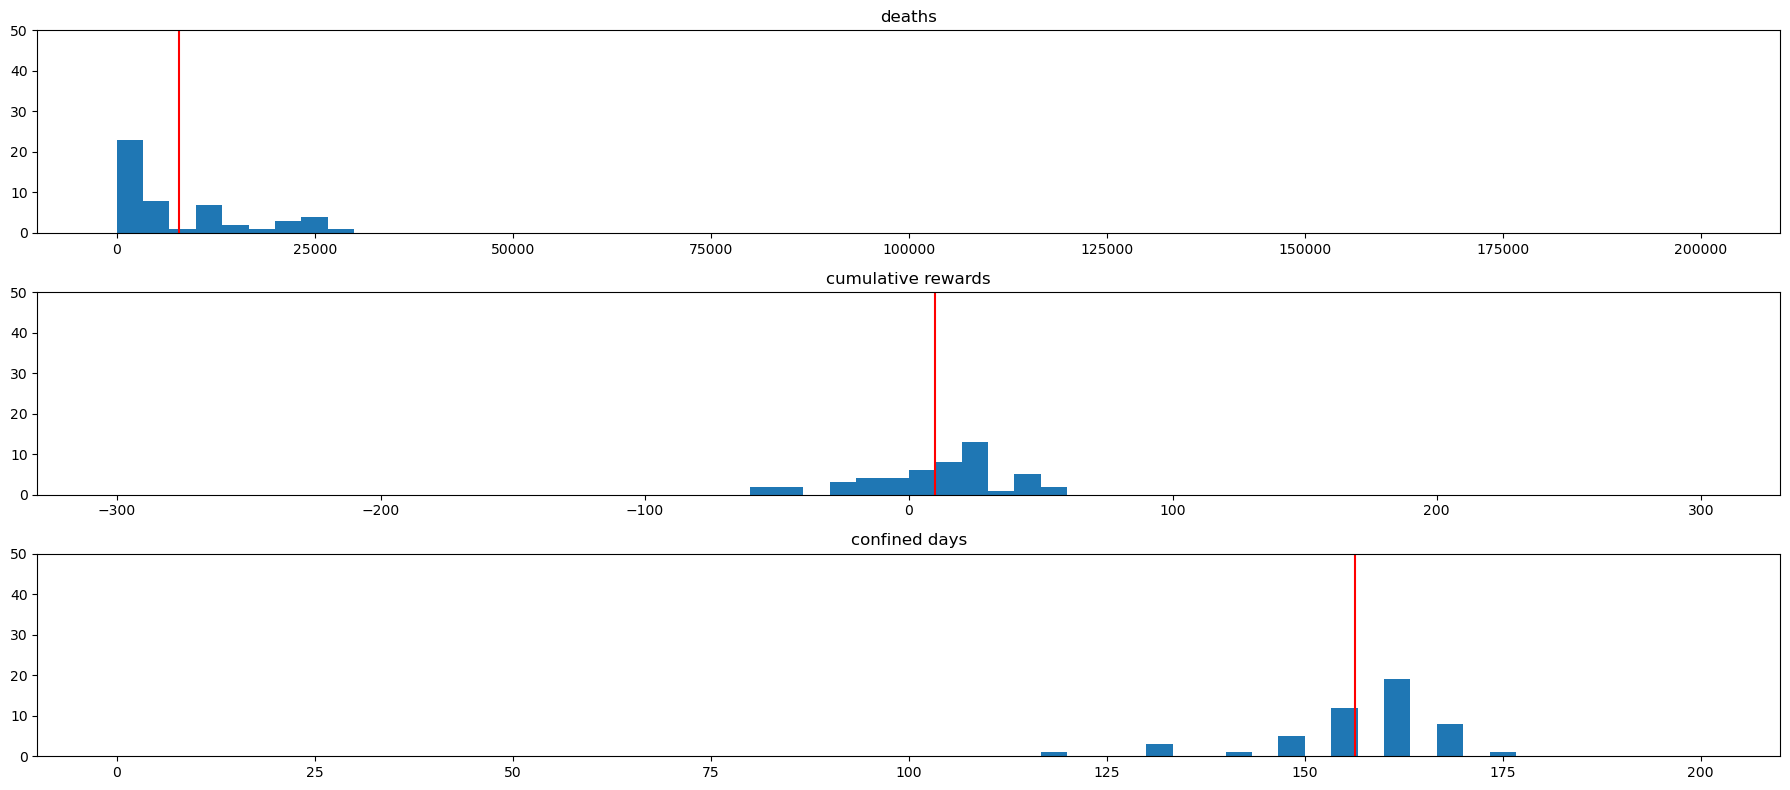

Average death number: 7882.12
Average number of confined days: 156.38
Average number of isolated days: 17.22
Average number of hospital days: 88.06
Average number of vaccine days: 12.6
Average cumulative reward: 10.000824079290032


In [141]:
""" Plot histogram """
# Get statistics
deaths, rewards, conf_days,isol_days,hosp_days,vacc_days  = get_statistics(env_m, DQNagent)

# Plot histogram
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (0,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')

fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average number of isolated days: {np.mean(isol_days)}')
print(f'Average number of hospital days: {np.mean(hosp_days)}')
print(f'Average number of vaccine days: {np.mean(vacc_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')

### 4.2 Factorized Q-values, multi-action agent

sampled action : [1 0 0 0]
Sampled observation


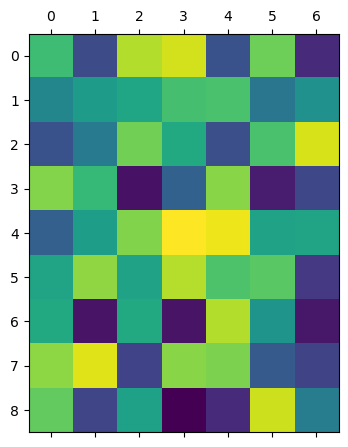

In [142]:
""" Re-design the action space and observation space """
action_space        =   spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[1,:,:])
plt.show()

SCALE = 100

def action_preprocessor_m(a:torch.Tensor, dyn:ModelDynamics):
    action_list = a.squeeze()
    # Interpret action tensor into dictionary
    action = {
        'confinement': bool(action_list[0]), 
        'isolation': bool(action_list[1]), 
        'hospital': bool(action_list[2]), 
        'vaccinate': bool(action_list[3]),
    }

    return action

def observation_preprocessor_m(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 0.25)
    dead = SCALE * np.power( np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 0.25)

    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [143]:
"""initialize a new environment"""
env_m = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_m,
            observation_preprocessor=observation_preprocessor_m,
            )

In [144]:
""" Define multi action factorized agent """
class DQNAgentMultiFactor(Agent):
    def __init__(self,  env:Env, epsilon:float = 0.7, batch_size: int = 2048, buffer_size: int = 20000, device = 'cuda', GAMMA : float = 0.9,
                 lr : float = 1e-5, policy_net = None, target_net = None, optimizer = None,
                # Additionnal parameters to be added here
                ):
        self.epsilon = epsilon
        self.env = env
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory_initial()
        self.device = device
        self.GAMMA = GAMMA
        self.lr = lr
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

    def save_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        torch.save(self.policy_net.state_dict(), savepath)
        pass

    def load_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        self.policy_net.load_state_dict(torch.load(savepath))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        pass

    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    # the action function for Q3a
    def act(self, obs, temp_epsilon):
        # write the epsilon-greedy policy here
        if random.random() < temp_epsilon:
            return int_to_tensor( self.env.action_space.sample()).unsqueeze(0) 
        else:
            m = self.policy_net(obs.to(self.device)).view(1, 8)
            output_2d = m.view(-1, 2)

            _, topk_indices = torch.topk(output_2d, k=1)

            tensor = torch.tensor([int(i[0]) for i in topk_indices])
            
            return torch.reshape(tensor,(1, 1, 4)).to(device) # return the action with the highest q-value
        

    # the action functio for Q3b
    def act_decay(self, obs, epsilon0, epsilonmin, Tmax, t):
        temp_epsilon = np.max([epsilon0*(Tmax-t)/Tmax, epsilonmin])
        return self.act(obs, temp_epsilon)
        
    def memory_initial(self):
        # initialize the memory
        self.memory = deque([],maxlen= self.buffer_size) # define the memory as a deque of size capacity

    def memory_push(self, transition):
        # push a transition into the memory
        self.memory.append(transition)

    def memory_sample(self):
        # sample a batch from memory
        return random.sample(self.memory, self.batch_size)
    
    def memory_len(self):
        # return the length of the memory
        return len(self.memory)
    
    def optimize_model(self, train = True):
        # This is where one would define the optimization step of an RL algorithm
        if self.memory_len() < self.batch_size:
            return 0
        transitions = self.memory_sample()

        batch = Transition(*zip(*transitions)) # unzip the batch

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device= self.device, dtype=torch.bool).to(device)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)

        state_batch = torch.cat(batch.state).to(device)
        
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).squeeze().to(device)

        action_batch = action_batch.long()
        
        state_action_values = torch.sum(self.policy_net(state_batch).gather(1, action_batch), dim=1, keepdim=True).to(device)

        next_state_values = torch.zeros(self.batch_size, device= self.device)


        with torch.no_grad():
            result = self.target_net(non_final_next_states)
            output_2d = result.view(self.batch_size, -1, 2)

            topk_values, _ = torch.topk(output_2d, dim = 2, k = 1)

            topk_values.reshape(self.batch_size, 4)
            
            next_state_values[non_final_mask] = torch.sum(topk_values, dim = 1, keepdim=True).reshape(self.batch_size)
        # Compute the expected Q values

        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
                
        criterion = nn.MSELoss() # define the loss function

        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        if train == True:
            # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100) 
            self.optimizer.step()
        return loss.item()
    
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

### Question 4.2.a: multi-action factorized Q-values policy training

In [145]:
""" Macros """
random_seed = 42 
BATCH_SIZE = 2048
GAMMA = 0.9
LR = 1e-3
input_dim = 2 * dyn.n_cities * dyn.env_step_length

In [146]:
""" Define training function """
def train_Q4b(experiment_id):

    env = env_m
    print(f"Experiment {experiment_id}")
    print('-------------------------------------------')

    # Initialize policy and target network
    policy_net = DQN(input_dim, 8).to(device)
    target_net = DQN(input_dim, 8).to(device)
    # Initialize the target network to be the same as the policy network
    target_net.load_state_dict(policy_net.state_dict()) 

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    DQNagentb = DQNAgentMultiFactor(env, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                    policy_net=policy_net, target_net=target_net, optimizer=optimizer)

    train_loss_trace = []
    train_reward_trace = []
    eval_loss_trace = []
    eval_reward_trace = []

    best = -np.inf

    for i in range(1,501):
        reward, loss = one_episode_decay(env,DQNagentb,i,0.7,0.2,500,i)
        train_loss_trace.append(loss)
        train_reward_trace.append(reward)
        if i % 5 == 0:
            # update target net
            DQNagentb.update_target_model()
        if i % 50 == 0 :
            # perform evaluation
            tuple_list = np.array([eval_one(env,DQNagentb,m) for m in range(20)])
            eval_losss = np.mean(tuple_list,axis = 0)[1]
            eval_rewards = np.mean(tuple_list,axis = 0)[0]

            eval_loss_trace.append(eval_losss)
            eval_reward_trace.append(eval_rewards)
            train_loss = np.mean(train_loss_trace[i-50:i-1])
            train_reward = np.mean(train_reward_trace[i-50:i-1])
            
            if eval_rewards > best:
                best = eval_rewards
                torch.save(DQNagentb.policy_net.state_dict(), f"DQN_best_Q4b_{experiment_id}.pth")   

            # Print log
            print(f"Episode {i} : train_reward {train_reward}, train_loss {train_loss}")
            print(f"Episode {i} : eval_reward {eval_rewards}, eval_loss {eval_losss}")

    # record the train_loss trace in corresponding experiment_id
    with open(f'Q4b_train_loss_{experiment_id}.json', 'w') as f: json.dump(train_loss_trace, f)
    with open(f'Q4b_train_reward_{experiment_id}.json', 'w') as f: json.dump(train_reward_trace, f)
    with open(f'Q4b_eval_loss_{experiment_id}.json', 'w') as f: json.dump(eval_loss_trace, f)
    with open(f'Q4b_eval_reward_{experiment_id}.json', 'w') as f: json.dump(eval_reward_trace, f)

In [ ]:
""" Perform experiments """
for i in range(1,4):
    train_Q4b(i)

In [148]:
""" Load trained model """
# Initialize policy and target network
policy_net = DQN(input_dim, 8).to(device)
target_net = DQN(input_dim, 8).to(device)
# Initialize the target network to be the same as the policy network
target_net.load_state_dict(policy_net.state_dict()) 

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
DQNagent = DQNAgentMultiFactor(env_m, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                    policy_net=policy_net, target_net=target_net, optimizer=optimizer)

DQNagent.load_model('DQN_best_Q4b_all.pth')

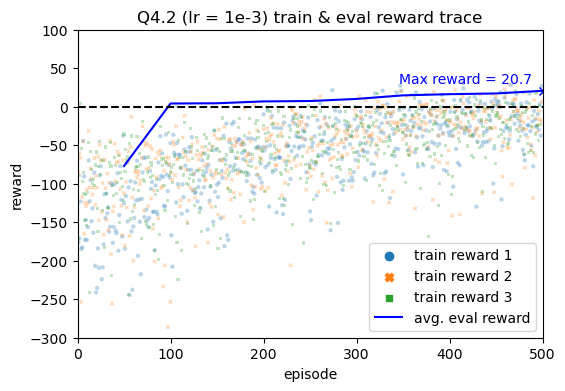

In [149]:
""" Plot traces"""
plot_trace('Q4b','Q4.2 (lr = 1e-3)', False)

In [156]:
""" Define plot functions to read data and plot toggle and factor together"""
def load_train_test_data(stage:str):
    #combine json into a dataframe
    with open(stage + '_json/' + stage +'_train_reward_1.json') as f:
        data1 = json.load(f)
        data1 = pd.DataFrame(data1)
        data1.columns = [ 'reward1']
    with open(stage + '_json/' + stage +'_train_reward_2.json') as f:
        data2 = json.load(f)
        data2 = pd.DataFrame(data2)
        data2.columns = [ 'reward2']
    with open(stage + '_json/' + stage +'_train_reward_3.json') as f:
        data3 = json.load(f)
        data3 = pd.DataFrame(data3)
        data3.columns = ['reward3']
    data = pd.concat([data1, data2, data3],axis=1)
    train_data = data.reset_index()
    train_data.columns = ['episode', 'reward1', 'reward2', 'reward3']

    with open(stage + '_json/' + stage +'_eval_reward_1.json') as f:
        data1 = json.load(f)
        data1 = pd.DataFrame(data1)
        data1.columns = [ 'reward1']
    with open(stage + '_json/' + stage +'_eval_reward_2.json') as f:
        data2 = json.load(f)
        data2 = pd.DataFrame(data2)
        data2.columns = [ 'reward2']
    with open(stage + '_json/' + stage +'_eval_reward_3.json') as f:
        data3 = json.load(f)
        data3 = pd.DataFrame(data3)
        data3.columns = ['reward3']
    data = pd.concat([data1, data2, data3],axis=1)
    test_data = data.apply(lambda x: x.mean(), axis=1)

    test_data = test_data.reset_index()

    test_data.columns = ['episode', 'reward']
    test_data['episode'] = (test_data['episode'] + 1)*50

    return train_data,test_data

def plot_trace_toggle_factor(stage: str,stage2: str, name: str, name2: str):
    train_data,test_data = load_train_test_data(stage)


    plt.figure(figsize=(6, 4),dpi = 100)
    # Reshape the DataFrame to have a single 'reward' column
    train_data_melted = train_data.melt(id_vars=['episode'], var_name='reward', value_name='value')

    # Plot the scatter plot
    sns.scatterplot(data=train_data_melted, x='episode', y='value', alpha=0.3, s = 10, label= name +' train reward')

    sns.lineplot(x='episode', y='reward', data=test_data, color='red', markers=True, dashes=False,label = name +' eval reward')
    # mark the maximum value of the lineplot
    plt.plot(test_data['episode'][test_data['reward'].idxmax()], test_data['reward'].max(), 'rx')
    # lable the maximum value with red color of the lineplot using red color
    plt.text(test_data['episode'][test_data['reward'].idxmax()]-144, test_data['reward'].max()-28, 'Max reward = {}'.format(round(test_data['reward'].max(), 1)), color='red')

    train_data,test_data = load_train_test_data(stage2)
    # Reshape the DataFrame to have a single 'reward' column
    train_data_melted = train_data.melt(id_vars=['episode'], var_name='reward', value_name='value')

    # Plot the scatter plot
    sns.scatterplot(data=train_data_melted, x='episode', y='value', alpha=0.3, s = 10, label= name2 +' train reward')

    sns.lineplot(x='episode', y='reward', data=test_data, color='blue', markers=True, dashes=False,label = name2 +' eval reward')
    # mark the maximum value of the lineplot
    plt.plot(test_data['episode'][test_data['reward'].idxmax()], test_data['reward'].max(), 'bx')
    # lable the maximum value with red color of the lineplot using red color
    plt.text(test_data['episode'][test_data['reward'].idxmax()]-144, test_data['reward'].max()+15, 'Max reward = {}'.format(round(test_data['reward'].max(), 1)), color='blue')


    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.xlim(0, 500)
    plt.ylim(-300, 100)
    plt.legend(loc='lower right')
    # plot a base line for y = 0
    plt.plot([0, 500], [0, 0], 'k--')

    plt.title(name + ' & ' + name2+ ' train & eval reward trace')
    plt.show()

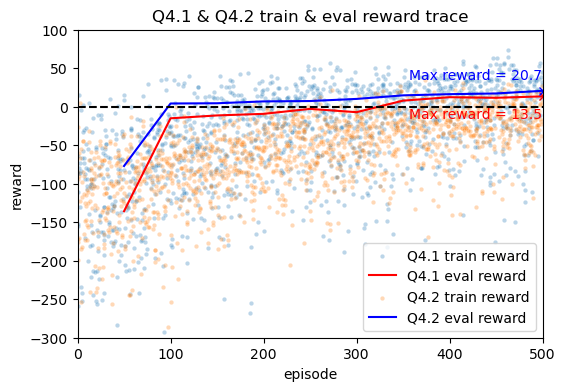

In [158]:
""" Plot toggle and factor together """
plot_trace_toggle_factor('Q4','Q4b','Q4.1','Q4.2')

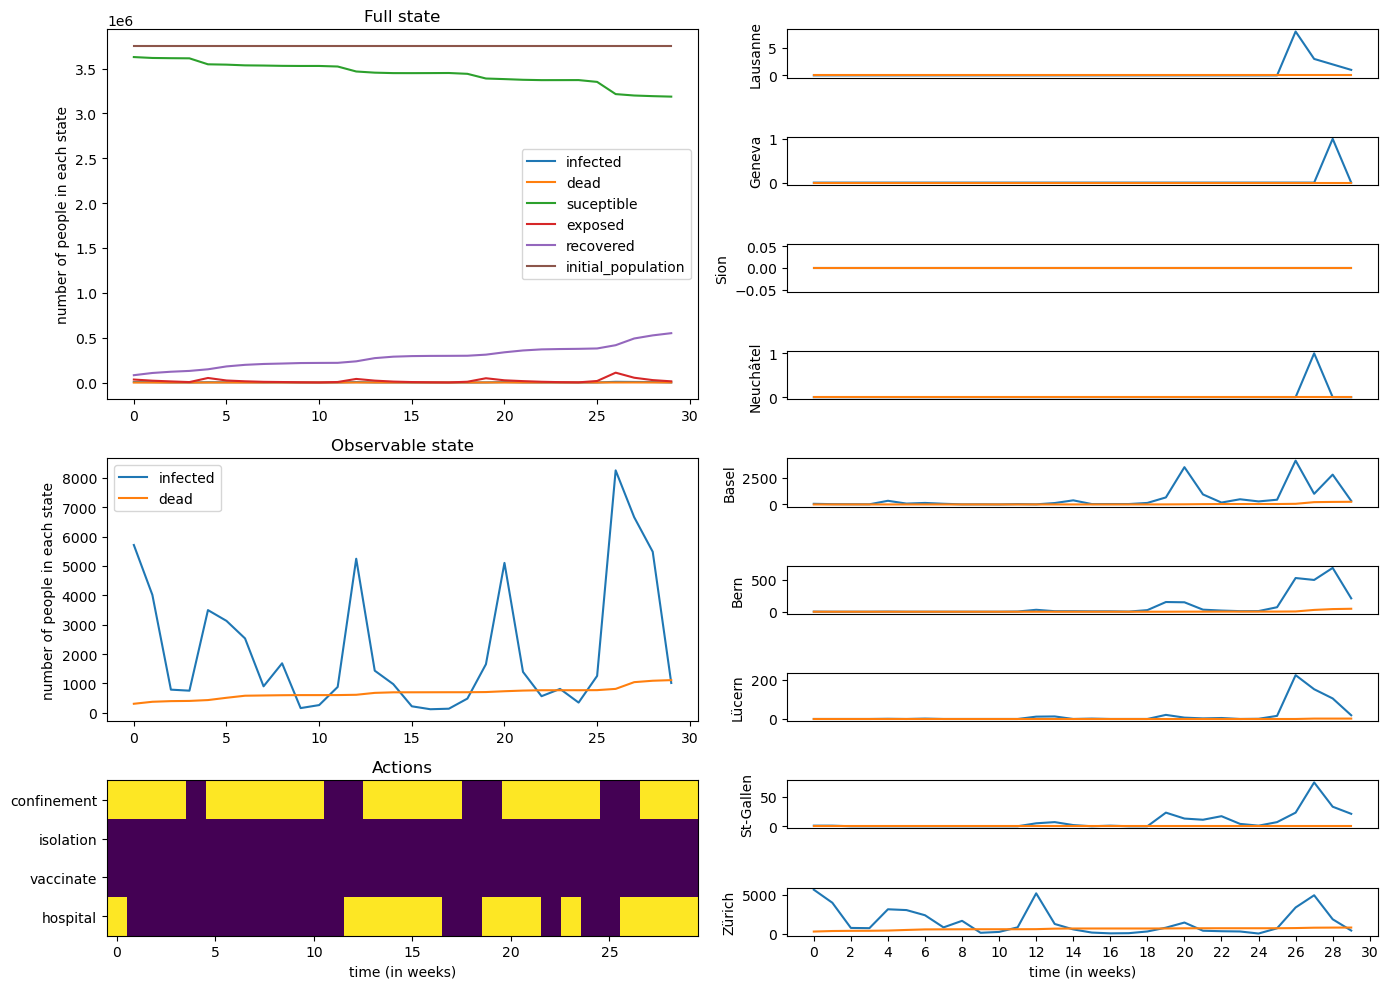

In [153]:
""" Run one episode """
log2 = []
finished = False
obs, info = env_m.reset(15)

while not finished:
    action = DQNagent.act(obs,0)
    obs, R, finished, info = env_m.step(action)
    log2.append(info) # save the information dict for logging
    if finished:
        break

plot(log2)

### Question 4.2.b: multi-action factorized Q-values policy evaluation

In [154]:
""" Define statistic function """
# this function runs 50 episodes and gather deaths rewards and total days of different actions
def get_statistics(env, agent):
    deaths_list, rewards_list, conf_days, isol_days, hosp_days, vacc_days = [],[],[],[],[],[]

    # Seeds for environment
    seeds = range(50)
    for i in range(50):
        total_deaths = 0
        total_rewards = 0
        total_conf = 0
        total_isol = 0
        total_hosp = 0
        total_vacc = 0
        
        finished = False
        obs, info = env.reset(seeds[i])

        confine = False
        isolate = False
        hospital = False
        vaccinate = False
  
        while not finished:
            action = agent.act(obs,0)

            # Interpret action and record it
            ac = action.tolist()[0][0]
            confine = ac[0]
            isolate = ac[1]
            hospital = ac[2]
            vaccinate = ac[3]

            total_conf += confine * 7
            total_isol += isolate * 7
            total_hosp += hospital * 7
            total_vacc += vaccinate * 7

            obs, R, finished, info = env.step(action)
            
            total_rewards += float(R)
            if finished:
                deaths_list.append(info.total.dead)
                break
        
        # Make lists
        conf_days.append(total_conf)
        isol_days.append(total_isol)
        hosp_days.append(total_hosp)
        vacc_days.append(total_vacc)
        rewards_list.append(total_rewards)

    return deaths_list, rewards_list, conf_days,isol_days,hosp_days,vacc_days

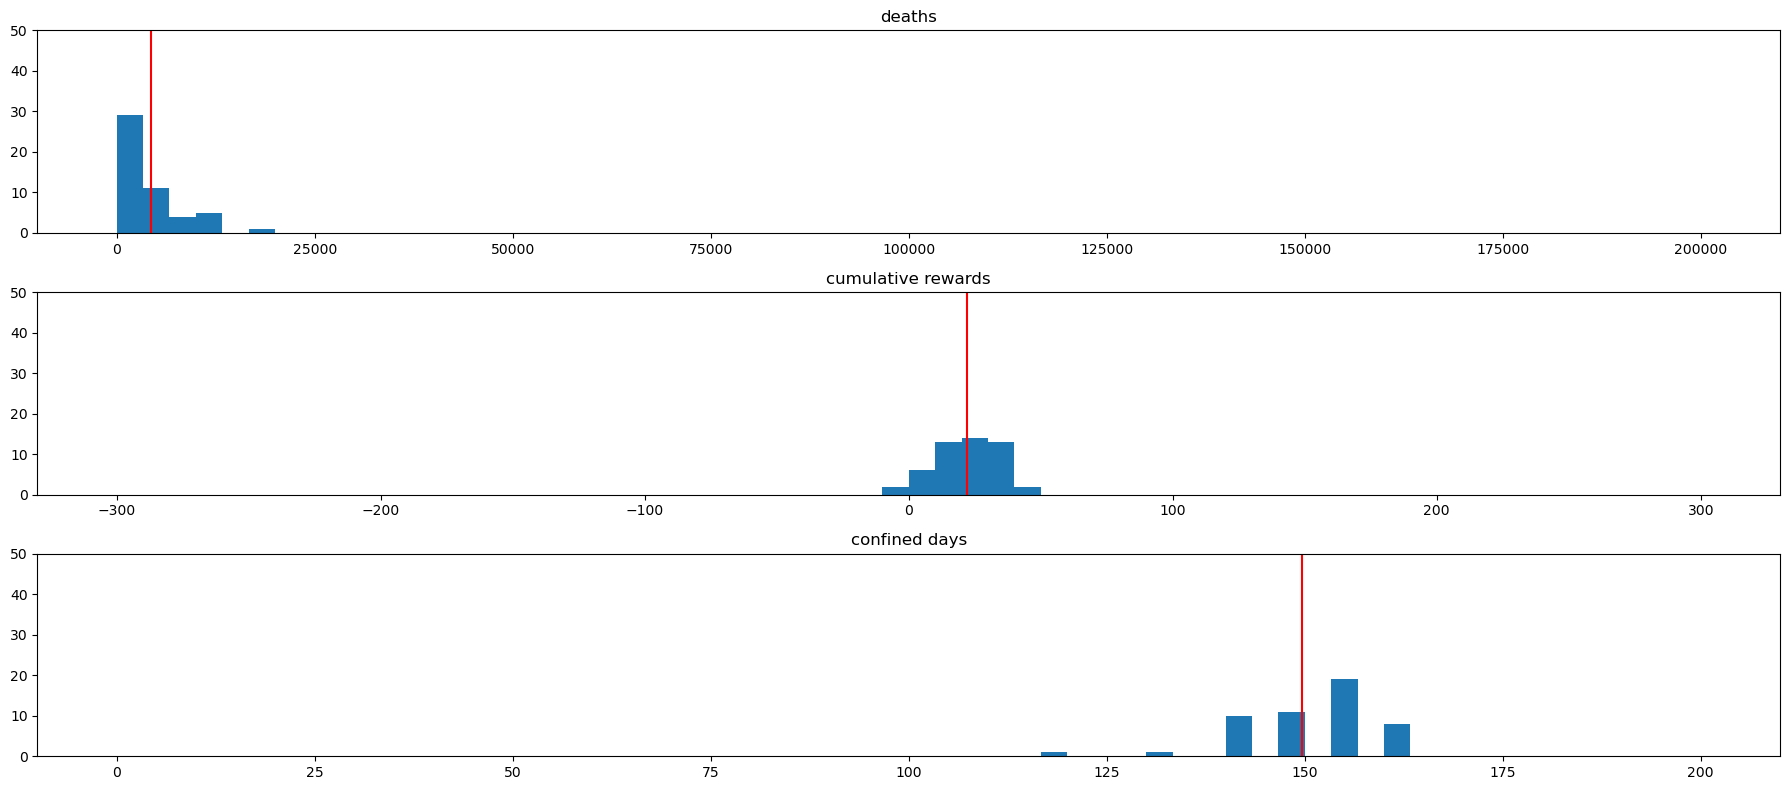

Average death number: 4340.66
Average number of confined days: 149.66
Average number of isolated days: 0.7
Average number of hospital days: 72.8
Average number of vaccine days: 0.28
Average cumulative reward: 21.889714371147566


In [155]:
""" Plot histogram """
# Get statistics
deaths, rewards, conf_days,isol_days,hosp_days,vacc_days  = get_statistics(env_m, DQNagent)

# Plot histogram
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (0,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')

fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average number of isolated days: {np.mean(isol_days)}')
print(f'Average number of hospital days: {np.mean(hosp_days)}')
print(f'Average number of vaccine days: {np.mean(vacc_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')

## 5: Wrapping Up

### Question 5.a: (Result analysis) Comparing the training behaviors

In [159]:
""" Define plot function to plot all traces """

def plot_test_individual(test_data, name, color, x_off, y_off):
    sns.lineplot(x='episode', y='reward', data=test_data, alpha = 0.6, markers=True, dashes=False,label = name +' eval reward',color=color)
    # mark the maximum value of the lineplot
    plt.plot(test_data['episode'][test_data['reward'].idxmax()], test_data['reward'].max(), 'x',color=color)
    # lable the maximum value with red color of the lineplot using red color
    plt.text(test_data['episode'][test_data['reward'].idxmax()]-x_off, test_data['reward'].max()-y_off, 'Max reward = {}'.format(round(test_data['reward'].max(), 1)),color=color)


def plot_trace_all(stages: list, names: list, colors:list, x_offsets:list, y_offsets:list):
    plt.figure(figsize=(6, 4),dpi = 100)

    # for each stage, load the traces file and plot the line
    for i in range(len(stages)):
    
        _,test_data = load_train_test_data(stages[i])

        plot_test_individual(test_data, names[i],colors[i],x_offsets[i],y_offsets[i])

    # plot russo's value
    russo_reward = -70.28 # this is obtained from Question 2b where average rewards for russo is calculated
    horizontal_line_data = pd.DataFrame({'episode': test_data['episode'], 'reward': russo_reward})
    
    sns.lineplot(x='episode', y='reward', data=horizontal_line_data, alpha=0.6, markers=True, dashes=False, label='Russo' + ' eval reward', color='magenta')
    
    # mark the maximum value of the lineplot
    plt.plot(horizontal_line_data['episode'][len(horizontal_line_data['reward']) - 1], horizontal_line_data['reward'].max(), 'x',color='magenta')
    
    # lable the maximum value with red color of the lineplot using red color
    plt.text(horizontal_line_data['episode'][len(horizontal_line_data['reward']) - 1]-154, horizontal_line_data['reward'].max()+5, 'Max reward = {}'.format(round(horizontal_line_data['reward'].max(), 1)),color='magenta')


    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.xlim(0, 500)
    plt.ylim(-150, 50)
    plt.legend(loc='lower right')
    # plot a base line for y = 0
    plt.plot([0, 500], [0, 0], 'k--')

    plt.title('All eval reward trace')
    plt.show()

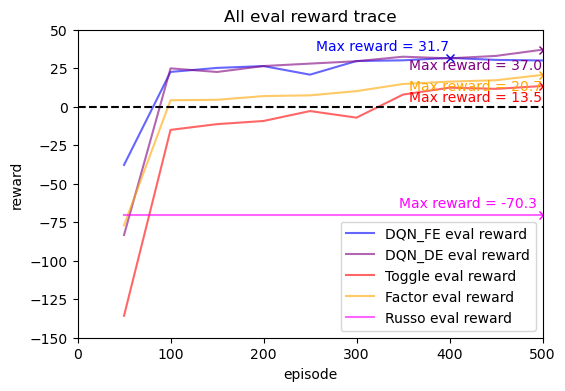

In [160]:
""" Plot all traces """
plot_trace_all(['Q3a','Q3b','Q4','Q4b'],
               ['DQN_FE','DQN_DE','Toggle','Factor'],
               ['blue','purple','red','orange'],
               [144,144,144,144],
               [-5,13,10,10]
               )

### Question 5.b: (Result analysis) Comparing policies

The statistics for all agents have been obtained at the end of each section. The results are:

#### Russo:

- Average death: 58922.9

- Average reward: -70.28965809565038

- Average confined days: 98.98

#### DQN (single action):

- Average death number: 3812.86

- Average number of confined days: 158.9

- Average cumulative reward: 32.061366457156836

### Toggle:

- Average death number: 7882.12

- Average number of confined days: 156.38

- Average number of isolated days: 17.22

- Average number of hospital days: 88.06

- Average number of vaccine days: 12.6

- Average cumulative reward: 10.000824079290032

### Factorized:

- Average death number: 4340.66

- Average number of confined days: 149.66

- Average number of isolated days: 0.7

- Average number of hospital days: 72.8

- Average number of vaccine days: 0.28

- Average cumulative reward: 21.889714371147566

### Question 5.c: (Interpretability) Q-values

In [212]:
""" Define statistics function for heatmap plots for Q3 and Q4.2 """
def heatmap_stats_Q3(env, agent, random_seed):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0
    lst = []
    actions = []
    while not done:
        action = agent.act(state,0)
        lst.extend(agent.policy_net(state.to(device)).tolist())
        actions.append(action.item())
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        loss = agent.optimize_model(train = False)
        total_loss += loss
    
    return total_reward.item(), total_loss, lst, actions

def heatmap_stats_Q4_2(env, agent, random_seed):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0
    lst = []
    actions = []
    while not done:
        action = agent.act(state,0)
        lst.extend(agent.policy_net(state.to(device)).tolist())
        actions.extend(action.tolist()[0])
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        loss = agent.optimize_model(train = False)
        total_loss += loss
    
    return total_reward.item(), total_loss, lst, actions

In [213]:
""" Load the agents """

""" Macros"""
seed = 42
BATCH_SIZE = 2048
LR = 5e-3
BATCH_SIZE = 20000
GAMMA = 0.9
input_dim = 2 * dyn.n_cities * dyn.env_step_length

""" Load Q3 agent """
# Initialize policy and target network
policy_net = DQN(input_dim, 2).to(device)
target_net = DQN(input_dim, 2).to(device)
# Initialize the target network to be the same as the policy network
target_net.load_state_dict(policy_net.state_dict()) 


optimizer = optim.Adam(policy_net.parameters(), lr=LR)
DQNagentb = DQNAgent(env, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                policy_net=policy_net, target_net=target_net, optimizer=optimizer)

DQNagentb.load_model("DQN_best_Q3b_all.pth")


""" Load Q4 agent """
# Initialize policy and target network
policy_net = DQN(input_dim, 8).to(device)
target_net = DQN(input_dim, 8).to(device)
# Initialize the target network to be the same as the policy network
target_net.load_state_dict(policy_net.state_dict()) 

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
DQNagent = DQNAgentMultiFactor(env_m, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                    policy_net=policy_net, target_net=target_net, optimizer=optimizer)

DQNagent.load_model('DQN_best_Q4b_all.pth')

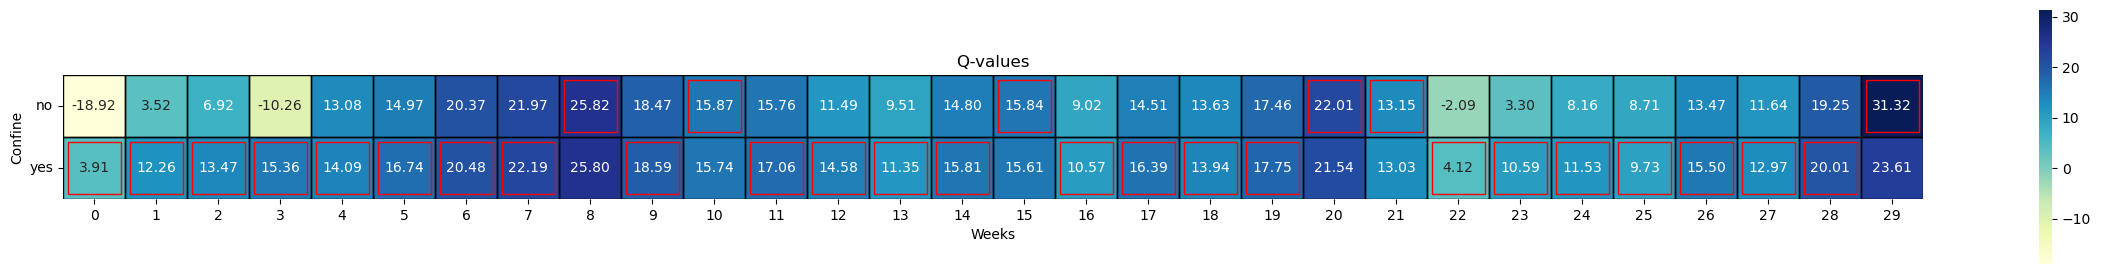

In [214]:
""" Plot heatmap for Q3 """
episode_seed = 2 # Episode seed

# Get statistics
_, _, lst, actions = heatmap_stats_Q3(env, DQNagentb, episode_seed)

# Convert to dataframe
df = pd.DataFrame(lst, columns=['no', 'yes']).T

# Set the figure size
plt.figure(figsize=(30, 15))
# Create the heatmap using Seaborn
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, cbar_kws={'shrink': 0.22})

# Get the current axis
ax = plt.gca()

# Set the aspect ratio to 'equal'
ax.set_aspect('equal')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

# Iterate over the cells and draw small rectangles
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        rect = plt.Rectangle((j, i), 1, 1, facecolor='none', edgecolor='black')
        ax.add_patch(rect)
        if(i % 2 == actions[j]):
            rect = plt.Rectangle((j + 0.075, i + 0.075), 0.85, 0.85, facecolor='none', edgecolor='red', alpha=1)
            ax.add_patch(rect)

# Set labels and title
plt.xlabel('Weeks')
plt.ylabel('Confine')
plt.title('Q-values')

# Display the plot
plt.show()

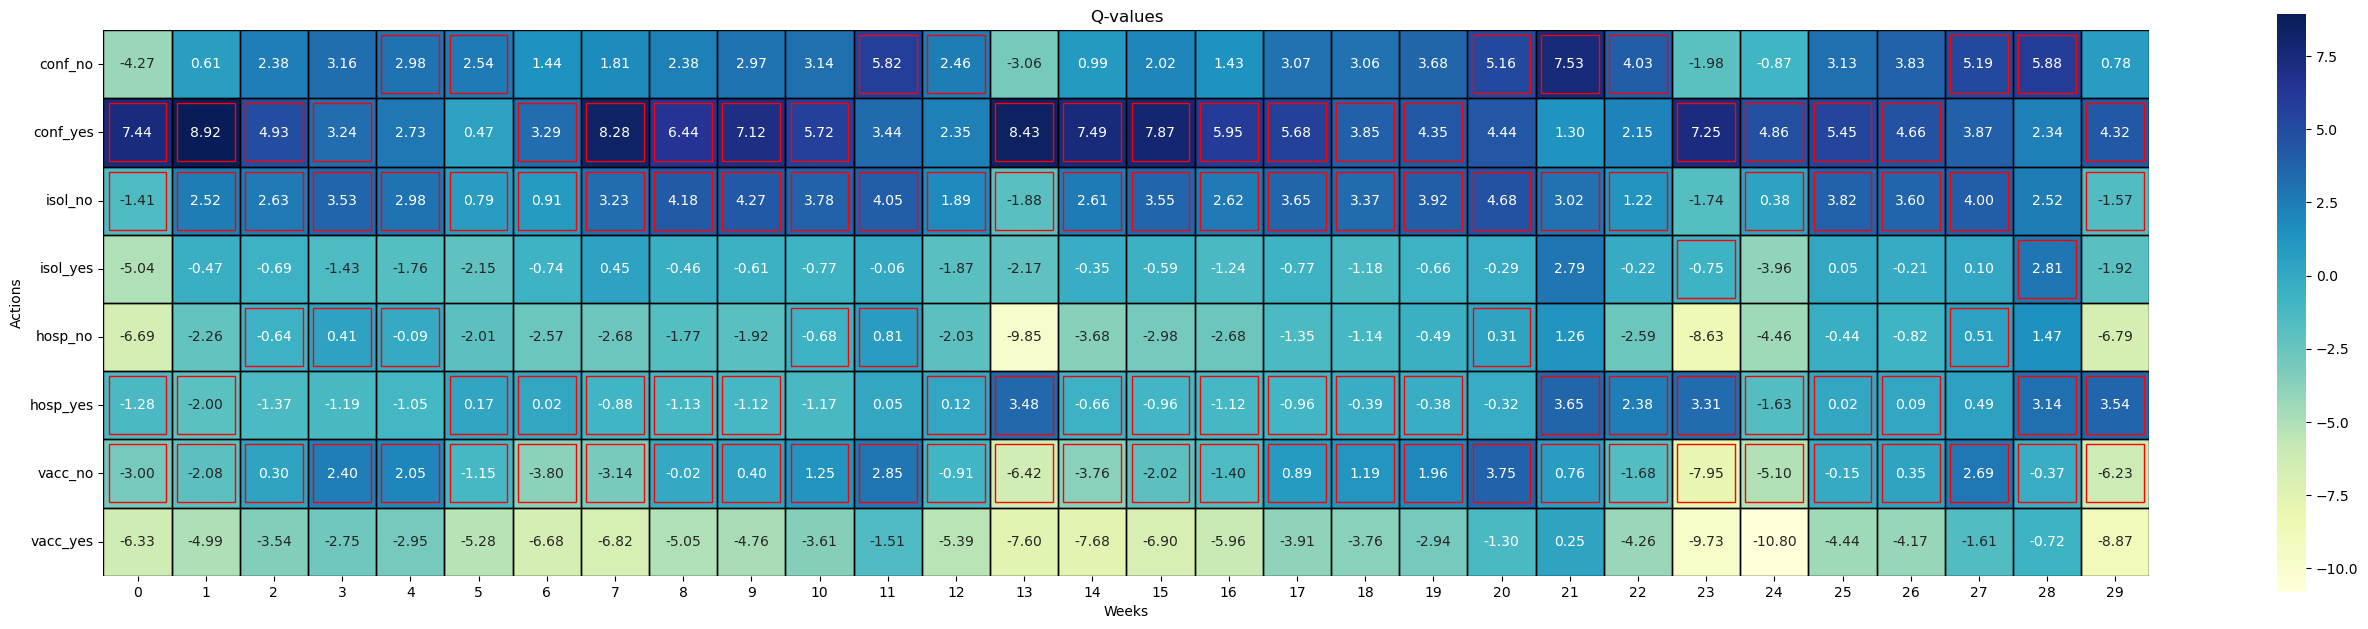

In [180]:
""" Plot heatmap for Q4.2 """
episode_seed = 2 # Episode seed

# Get statistics
_, _, lst, actions = heatmap_stats_Q4_2(env_m, DQNagent, episode_seed)

df = pd.DataFrame(lst, columns=['conf_no', 'conf_yes','isol_no', 'isol_yes','hosp_no', 'hosp_yes','vacc_no', 'vacc_yes']).T

# Set the figure size
plt.figure(figsize=(33, 15))
# Create the heatmap using Seaborn
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", yticklabels=True, cbar=True, cbar_kws={'shrink': 0.5})

# Get the current axis
ax = plt.gca()

# Set the aspect ratio to 'equal'
ax.set_aspect('equal')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
# Iterate over the cells and draw small rectangles
for i in range(df.shape[1]):
    count = 0
    for j in range(df.shape[0]):
        rect = plt.Rectangle((i, j), 1, 1, facecolor='none', edgecolor='black')
        ax.add_patch(rect)
        if (j%2 == actions[i][int(count/2)]):
            rect = plt.Rectangle((i + 0.075, j + 0.075), 0.85, 0.85, facecolor='none', edgecolor='red', alpha=1)
            ax.add_patch(rect)
        count += 1

# Set labels and title
plt.xlabel('Weeks')
plt.ylabel('Actions')
plt.title('Q-values')

# Display the plot
plt.show()